# CAB420 Assignment 1B Question 2: Template

## Overview

This notebook provides a helper function to load in the Oxford-IIIT Pets dataset suitable for classification and semantic segmentation, to help with Assignment 1B, Question 2.

It also provides an example of how to load in the MobileNetV3Small Network which you are required to fine tune for the second part of the question.

Please read the comments and instructions within this notebook. It has been carefully designed to help you with many of the tasks required.

Please make sure you read the assignment brief on canvas, and check the FAQ for other information.

In [23]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import matplotlib.pyplot as plt
from matplotlib import gridspec

import tensorflow as tf
import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, SpatialDropout2D, Activation, Flatten
from keras.models import Model

import numpy as np
import pandas as pd
import tensorflow_datasets as tfds
import glob
from tensorflow.keras import layers, Model
from keras.utils import model_to_dot, plot_model
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, ConfusionMatrixDisplay, classification_report

### Data loading and pre-processing functions

We first provide some helper functions to format the data in the way we need. You shouldn't need to change these, though you are welcome to if you like.

One thing you may want to do is create additional augmentation functions, and the ``flip_lr_augmentation`` function below could be used as a template to create additional augmentation types. 

In [24]:
def preprocess_segmentation_mask(segmentation_mask):
    """preprocess the semgentation mask

    The original segmentation mask has three categories.
      foreground, background and outline
    This function will just convert it to foreground and background 

    The original segmentation mask is also 1-index, so will convert it
    to 0-index.

    the original mask is represented as:
    1 - edge of dog/cat and things like leashes etc.
    2 - background
    3 - foreground

    we want to just keep the merge the edges and foreground of the doggo/catto, and
    then treat it as a binary semantic segmentation task.
    To achieve this, we will just subtract two, converting to values of [-1, 0, 1],
    and then apply the abs function to convert the -1 values (edges) to the foreground.

    Will also convert it to 32 bit float which will be needed for working with tf.
    
    Why am I doing it this way?
     A reasonable question. Initially I tried to do it with just normal array indexing,
     but this is a bit more work since the mask is a tensorflow tensor and not a np array.
     We could alternatively convert it to an array, perform indexing and then map it back,
     but this would have a performance overhead, which wouldn't be a big deal, but still.
     With all that being said, I am doing it for you, so you don't have to.

    Args:
      segmentation_mask (array):
        original segmentation mask

    Returns:
      preprocessed segmentation_mask
    """
    return tf.abs(tf.cast(segmentation_mask, tf.float32) - 2)

def return_image_label_mask(ds_out):
    """ function to return image, class label and segmentation mask

    The original dataset contains additional information, such as the filename and
    the species. We don't care about any of that for this work, so will
    discard them and just keep the original image as our input, and then
    a tuple of our outputs that will be the class label and the semantic
    segmentation mask.

    Whilst we are here, we will also preprocess the segmentation mask.

    Args:
      ds_out: dict
        original dataset output

    Returns:
       RGB image
       tuple of class label and preprocessed segmentation mask
    """
    # preprocess the segmentation mask
    seg_mask =  preprocess_segmentation_mask(ds_out['segmentation_mask'])
    image = tf.cast(ds_out['image'], tf.float32)
    # image = standardise_image(image)
    return image, (ds_out['label'], seg_mask)

def mobilenet_preprocess_image(image):
    """Apply preprocessing that is suitable for MobileNetV3.
    
    Simply scales to ranges [-1, 1]
    
    
    you should use this preprocessing for both your model and the mobilenet model
    """
    image = (image - 127.5) / 255.0
    return image
        
def unprocess_image(image):
    """ undo preprocessing above so can plot images"""
    image = image * 255.0 + 127.5
    return image

def preprocess_and_resize(image, output, image_size):
    """apply preprocessing steps above to images and resize images and maps
    
    Each image in the dataset is of a different size. The resizing will make sure
    each image is the same size.
    """
    # resize the image and the semantic segmentation mask
    image = tf.image.resize(image, [image_size, image_size])
    image = mobilenet_preprocess_image(image)
    mask = tf.image.resize(output[1], [image_size, image_size])
    return image, (output[0], mask)

def flip_lr_augmentation(image, output, flip_lr_prob):
    """ function to return perform left-right flip augmentation

    The function will flip the image along the left-right axis with
    a defined probability.
    """

    # randomly sample a value between 0 and 1
    uniform_sample = tf.random.uniform([], minval=0, maxval=1)
    # perform flip_lr with probability given by flip_lr_prob 
    flip_lr_cond = tf.math.less(uniform_sample, flip_lr_prob)
    # output is a tuple of (class, segmentation_mask), pull out the segmentation mask
    seg = output[1]
    
    # wrapper fn for when we do the flip
    def flip():
        flipped_image = tf.image.flip_left_right(image)
        flipped_seg = tf.image.flip_left_right(seg)
        return flipped_image, flipped_seg

    # wrapper fn for when we do NOT flip
    def no_flip():
        return image, seg

    # apply augmentation    
    image, seg = tf.cond(flip_lr_cond, flip, no_flip)
    # return the image, and output
    return image, (output[0], seg)

def select_tasks(image, output, classification=True, segmentation=True):
    """select the tasks to include the data

    By default for each input there are two outputs. This function allows
    you to select which outputs to use, so the problem can be reduced to a
    single task problem for initial experimenting.    
    """
    # both tasks
    if classification and segmentation:
        return image, output
    # just classification
    elif classification:
        return image, output[0]
    # just segmentation
    elif segmentation:
        return image, output[1]
    # neither task, doesn't really make sense, so return the image
    # for a self-supervised task
    else:
        return image, image

class TrainForTime(keras.callbacks.Callback):
    """callback to terminate training after a time limit is reached

    Can be used to control how long training runs for, and will terminate
    training once a specified time limit is reached.
    """
    def __init__(
        self,
        train_time_mins=15,
    ):
        super().__init__()

        self.train_time_mins = train_time_mins
        self.epochs = 0
        self.train_time = 0
        self.end_early = False

    def on_train_begin(self, logs=None):
        # save the start time
        self.start_time = tf.timestamp()

    def on_epoch_end(self, epoch, logs=None):
        self.epochs += 1
        current_time = tf.timestamp()
        training_time = (current_time - self.start_time)
        if (training_time / 60) > self.train_time_mins:
            self.train_time = current_time - self.start_time
            self.model.stop_training = True
            self.end_early = True


    def on_train_end(self, logs=None):
        if self.end_early:
            print('training time exceeded and ending early')
            print(f'training ended on epoch {self.epochs}')
            print(f'training time = {self.train_time / 60} mins')

### Data Loader

We will now put the above functions together into a data loader that we can use to feed directly to the network. You can you this directly as it is. However, you may modify it to add some additional functionality such as further data augmentations.

In [25]:
def load_oxford_pets(split,
                     batch_size=233,
                     classification=True,
                     segmentation=True,
                     shuffle=True,
                     augment=True,
                     image_size=300):
    """Load Oxford pets dataset for Assignment 1B

    Function handles loading of data for 1b, included processing of images and
    semantic segmentation masks. This function will
    organise the tensorflow dataset to return an output that is a tuple, where
    the tuple will be (classification_labels, segmentation_masks).

    Parameters
    ----------
    split : string
        either train or test string
    classification : bool
        whether to include classification labels
    segmentation : bool
        whether to include semantic segmentation masks
    batch_size : int
        size of batches to use
    shuffle : bool
        whether to shuffle the dataset (WILL ONLY APPLY TO TRAIN)
    augment : bool
        whether to augment the dataset (WILL ONLY APPLY TO TRAIN)
    image_size : int
        new image size

    Returns
    -------
       tf.Dataset containing the Oxford pets dataset
    """
    # lets do some error checking first
    # Check fior a valid dataset split, this must be train or test
    if (split != 'train') and (split != 'test'):
        raise ValueError('Arg for split must be either \'train\' or \'test\'')
    if (not classification) and (not segmentation):
        print("WARNING: One of the tasks (classification and segmentation) must be selected")
        print("Setting both to enabled")
        classification = True
        segmentation = True
    # check that if using the test split, shuffle if false. If not, print a warning and force shuffle to be false
    if (split == 'test') and shuffle:
        print("WARNING: shuffle is set to true, but have specified split to be \'test\'")
        print('The shuffle argument will be ignored')
        shuffle = False
    # check that if using the test split, augment if false. If not, print a warning and force augment to be false
    if (split == 'test') and augment:
        print("WARNING: augment is set to true, but have specified split to be \'test\'")
        print('The augment argument will be ignored')
        augment = False
   
    # now start loading the dataset
    ds = tfds.load('oxford_iiit_pet',
                   split=split,
                   with_info=False)
    
    # remove unnecessary dataset info
    ds = ds.map(return_image_label_mask)

    # augmentation
    # only apply if in the training split and augment has been set to True
    if split == 'train' and augment:
        # apply a left-right flip with 50% probability
        flip_lr_prob = 0.5
        # flip operation
        ds = ds.map(lambda inp, out: flip_lr_augmentation(inp, out, flip_lr_prob), num_parallel_calls=tf.data.AUTOTUNE)

        # more augmentation operations could go here .....
    
    # Final processing of the data 
    # here we will resize the data, and add the preprocessing that is needed for compatability with the mobilenet models.
    ds = ds.map(lambda inp, out: preprocess_and_resize(inp, out, image_size))

    # and now remove any tasks that we don't want. Note that we call this last as it means that all the other functions
    # can safely assume that data for both tasks is in the dataset
    ds = ds.map(lambda inp, out: select_tasks(inp, out, classification, segmentation))

    # if in the training split, and shuffle is true, shuffle the data
    if split == 'train' and shuffle:
        ds = ds.shuffle(1000)

    # return the loaded and processed dataset
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)


### Testing the provided data loader.

We'll now test the data loader and plot some examples to confirm it's working. **NOTE: some poor defaults are specified below for image size and batch size. Set these to something more appropriate.**

In [4]:
# testing the data loader and plotting some images.
# NOTE: the image size set here is all but definitely too large. You will need
# to chage this yourself to something that is suitable given your constraints
# NOTE: The batch size is also too large. This done on purpose force you to 
# pick a suitable batch size yourself
image_size = 300
batch_size = 273
# load training data, note that shuffle and augment are true
train_class_seg = load_oxford_pets('train', classification=True, segmentation=True, shuffle=True, augment=True, batch_size=batch_size, image_size=image_size)
# load testing data, note that shuffle and augment are false (though if they weren't, the data loader would force these to be false)
test_class_seg = load_oxford_pets('test', classification=True, segmentation=True, shuffle=False, augment=False, batch_size=batch_size, image_size=image_size)

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


(273, 300, 300, 1)
(273, 300, 300, 1)
(273, 300, 300, 1)


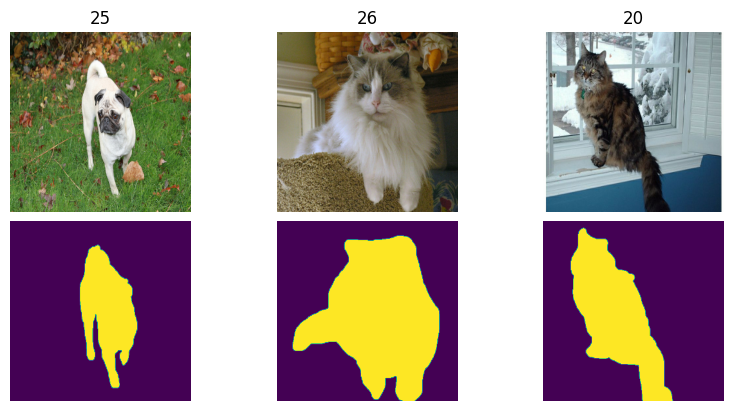

In [5]:
# lets plot a few now to see some good kittens/doggos
fig, axs = plt.subplots(2, 3, figsize=(8, 4), layout="constrained")
num_plot = 3
i = 0

# each sample of our dataset will be of the format
# image, outputs
# where outputs[0] = label
#       outputs[1] = segmentation mask
#
#
# lets get a single batch, and plot just a few of them
for image, output in train_class_seg.take(1).as_numpy_iterator(): 
    for i in range(num_plot): 
        im = axs[0, i].imshow(np.squeeze(unprocess_image(image[i, ...])) / 255.0)
        axs[0, i].set_title(output[0][i])
        axs[0, i].axis('off')
        im = axs[1, i].imshow(np.squeeze(output[1][i, ...]))
        axs[1, i].axis('off')
        
        print(output[1].shape)
        i += 1
        if i >= num_plot:
            break
        
plt.savefig('doggos_cattos.png')

# def plot_images(x, y):
#     fig = plt.figure(figsize=[15, 18])
#     for i in range(50):
#         ax = fig.add_subplot(5, 10, i + 1)
#         ax.imshow(x[i,:], cmap=plt.get_cmap('Greys'))
#         ax.set_title(y[i])
#         ax.axis('off')

The images are showing correctly.

**NOTE: You can ignore the JPEG wearning.**

We can use the ``classification`` and ``segmentation`` flags to pull out just one output as well, as the below demonstrates. 

In [6]:
# classification only; classification = True, segmentation = False (note batch size is 1 here)
train_class_only = load_oxford_pets('train', classification=True, segmentation=False, shuffle=True, augment=True, batch_size=1, image_size=image_size)
# segmentation only; classification = False, segmentation = True (note batch size is 1 here)
train_seg_only = load_oxford_pets('train', classification=False, segmentation=True, shuffle=True, augment=True, batch_size=1, image_size=image_size)

# test the classification only dataset
# pull out one element
inp, out = next(iter(train_class_only))
# print the output
print(out.numpy())

# test the segmentation only dataset
# pull out one element
inp, out = next(iter(train_seg_only))
# print just the output shape for the segmentation output 
print(out.numpy().shape)

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


[36]
(1, 300, 300, 1)


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


While for the question you do need to train networks to do both tasks simultaenously, when you starting playing with the problem it might be easier to get things working for one task, and then add the second.

### Loading MobileNetV3Small base for fine tuning

This model can be loaded directly from keras. By default, the model we download will be pre-trained on Imagenet dataset.

Note that we will need to set the preprocessing option when loading this base network to False. This is because the `include_preprocessing` step is implemented in the Datasets we defined above.

We also set `include_top=False`, to avoid loading our model with the final Dense classification layer which is used for the original Imagenet model.

More details are available in the keras documentation [here](https://keras.io/api/applications/mobilenet/).

In [7]:
mobile_base = keras.applications.MobileNetV3Small(input_shape=(image_size, image_size, 3),
                                                  include_top=False,
                                                  include_preprocessing=False)

/home/imhaom/.local/lib/python3.11/site-packages/keras/src/applications/mobilenet_v3.py:449: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


For this task, can ignore the input_shape warning, though it is important to keep in mind the difference in size of data used for the pre-trained model and our data may have an impact on our model (what that impact might be is for you to investigate :) ). Depending on what input shape you select you may also be able to eliminate this.

For more information on fine-tuning models, can refer to many of the examples from class, or the [Keras documentation](https://keras.io/guides/transfer_learning/)

## Question 2 Template

The following provides a starting point for your solution, and some suggestions on how to proceed.

In [26]:
#
# Data loading
#
# Use the provided data loader, setting your batch size and image size appropriately.
# Note that you may want to add more augmentation into the data loader.
# For initial experiments you may also want to turn one of classification or segmentation off to allow you to play with a single task.
image_size = 256 # WARNING: THIS VALUE IS STUPID
batch_size = 32 # WARNING: THIS VALUE IS STUPID
# load training data, note that shuffle and augment are true
train_class_seg = load_oxford_pets('train', classification=True, segmentation=True, shuffle=True, augment=True, batch_size=batch_size, image_size=image_size)
# load testing data, note that shuffle and augment are false (though if they weren't, the data loader would force these to be false)
test_class_seg = load_oxford_pets('test', classification=True, segmentation=True, shuffle=False, augment=False, batch_size=batch_size, image_size=image_size)

# Note that you may also want a non-shuffled version of the training set to help you evaluate training performance. You could simply create another
# training set object with the same settings, but shuffle set to False, i.e.
# train_class_seg_ns = load_oxford_pets('train', classification=True, segmentation=True, shuffle=False, augment=True, batch_size=batch_size, image_size=image_size)

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 256, 256,  │       0 │ -                    │
│ (InputLayer)        │ 3)                │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 256, 256,  │     896 │ input_layer_7[0][0]  │
│                     │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │       0 │ conv2d_8[0][0]       │
│ (MaxPooling2D)      │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dropout_10          │ (None, 128, 128,  │       0 │ max_pooling2d_4[0][… │
│ (Dropout)           │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 128, 128,  │  18,496 │ dropout_10[0][0]     │
│                     │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ max_pooling2d_5     │ (None, 64, 64,    │       0 │ conv2d_9[0][0]       │
│ (MaxPooling2D)      │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dropout_11          │ (None, 64, 64,    │       0 │ max_pooling2d_5[0][… │
│ (Dropout)           │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 64, 64,    │  73,856 │ dropout_11[0][0]     │
│                     │ 128)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ max_pooling2d_6     │ (None, 32, 32,    │       0 │ conv2d_10[0][0]      │
│ (MaxPooling2D)      │ 128)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dropout_12          │ (None, 32, 32,    │       0 │ max_pooling2d_6[0][… │
│ (Dropout)           │ 128)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 32, 32,    │ 295,168 │ dropout_12[0][0]     │
│                     │ 256)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ max_pooling2d_7     │ (None, 16, 16,    │       0 │ conv2d_11[0][0]      │
│ (MaxPooling2D)      │ 256)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dropout_13          │ (None, 16, 16,    │       0 │ max_pooling2d_7[0][… │
│ (Dropout)           │ 256)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 16, 16,    │ 1,180,… │ dropout_13[0][0]     │
│                     │ 512)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_transpose_14 │ (None, 32, 32,    │ 2,359,… │ conv2d_12[0][0]      │
│ (Conv2DTranspose)   │ 512)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ global_average_poo… │ (None, 512)       │       0 │ conv2d_12[0][0]      │
│ (GlobalAveragePool… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_transpose_15 │ (None, 64, 64,    │ 1,179,… │ conv2d_transpose_14

 Total params: 5,618,022 (21.43 MB)

 Trainable params: 5,618,022 (21.43 MB)

 Non-trainable params: 0 (0.00 B)

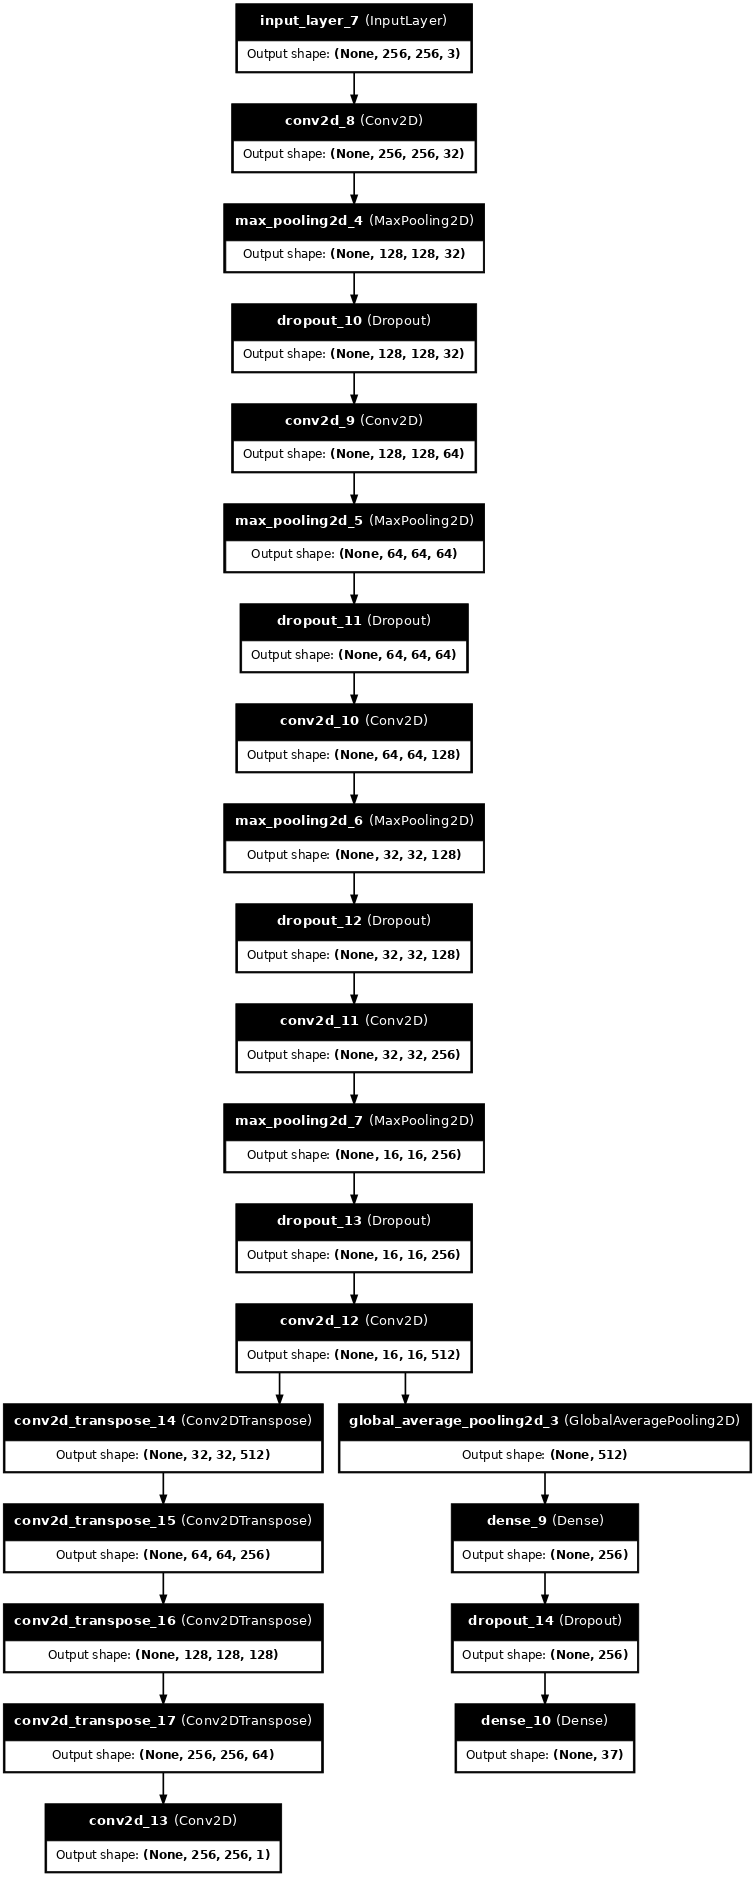

In [40]:
# 
# From-scratch DCNN
#
# Put your from-scratch DCNN here. This network will have one input (the input image), and two outputs (the class, and the segmentation map). You can
# think of your model as having three components:
#  - A backbone, which is going to take your input and encode that. This will possibly be collection of (probably mostly) 2D convolution layers 
#    and max pooling layers (and for which you may be able to find something fairly fit for purpose in lecture or prac examples).
#  - A classification head, which will take the backbone output and via one or more dense layers do the classification task. This will likely only
#    be a few layers at most.
#  - A decoder head, which will do the semantic segmentation. This will look a lot like the back half of an autoencoder.
#
# As usual, the network does not need to be overly complex, but you will need to briefly explain your selection of this model, and you should avoid 
# networks so simple that they perform very badly.
#
# Take note of the order that the outputs appear in the data loader. The data loader will give you (classification_output, segmentation_output), so
# your network should have the outputs in the same order.
#
# When first developing your model, you may want to start by getting a single output of the network going, and then adding the second output. For
# example, you may build a network with the image input and the just the classification head, get that running, and then add the decoder head. You can
# use the classification and segmentation flags in the data loader to turn off one of the outputs.

# For model training, we have provided a callback, TrainForTime, which will terminate training after some time limit is reached. You could use this
# as follows:
#   train_time = 15 # 15-minute training limit
#   my_awesome_model.fit(train_class_seg, epochs=epochs, verbose=True, validation_data=test_class_seg, callbacks=[TrainForTime(train_time)])
# You don't have to use this, but you may wish to use this to ensure training doesn't take too long.
# Note that if you don't train until convergence, you will need to explain what you observe with training and what the implications of this are.

# Define from-scratch DCNN model
def build_dcnn_model(image_size=256, num_classes=37):
    input_img = layers.Input(shape=(image_size, image_size, 3))
    l2_reg = l2(1e-4)
    # Backbone Network
    x = input_img
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPool2D((2, 2), strides=(2, 2))(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPool2D((2, 2), strides=(2, 2))(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPool2D((2, 2), strides=(2, 2))(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPool2D((2, 2), strides=(2, 2))(x)
    x = layers.Dropout(0.4)(x)

    backbone_output = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2_reg)(x)

    # Classification Head
    classification_head = layers.GlobalAveragePooling2D()(backbone_output)
    classification_head = layers.Dense(256, activation='relu')(classification_head)
    classification_head = layers.Dropout(0.5)(classification_head)
    classification_head = layers.Dense(num_classes, activation='softmax', dtype='float32')(classification_head)

    # Segmentation Head
    segmentation_head = layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), activation='relu', padding='same')(backbone_output)
    segmentation_head = layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), activation='relu', padding='same')(segmentation_head)
    segmentation_head = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), activation='relu', padding='same')(segmentation_head)
    segmentation_head = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu', padding='same')(segmentation_head)
    segmentation_head = layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same', dtype='float32')(segmentation_head)

    model = Model(inputs=input_img, outputs=[classification_head, segmentation_head])
    return model

# Build and compile the improved DCNN model
dcnn_model = build_dcnn_model(image_size=image_size, num_classes=37)
# Classification head: 'accuracy'
# Segmentation head: 'accuracy'
dcnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=[tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 'binary_crossentropy'],
    metrics=[tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 'binary_crossentropy']
)

dcnn_model.summary()
plot_model(dcnn_model, show_shapes=True, show_layer_names=True, dpi = 60)

In [10]:
# Train the model
# train_time = 15  # 15-minute training limit

# checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     'checkpoint_epoch_{epoch:02d}.weights.h5',
#     # save_best_only=True,
#     save_weights_only=True,
#     monitor='val_loss',
#     verbose=1
# )

history = dcnn_model.fit(
    train_class_seg,
    epochs=60,
    verbose=1,
    validation_data=test_class_seg,
    #callbacks=[checkpoint_callback]
)

print(f"Available keys in history: {history.history.keys()}")

Epoch 1/60


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
I0000 00:00:1715469677.069907   47109 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


115/115 ━━━━━━━━━━━━━━━━━━━━ 44s 150ms/step - conv2d_5_binary_crossentropy: 0.6618 - dense_2_sparse_categorical_crossentropy: 3.6175 - loss: 4.3060 - val_conv2d_5_binary_crossentropy: 0.5725 - val_dense_2_sparse_categorical_crossentropy: 3.6109 - val_loss: 4.1945
Epoch 2/60


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step - conv2d_5_binary_crossentropy: 0.5608 - dense_2_sparse_categorical_crossentropy: 3.6127 - loss: 4.1827 - val_conv2d_5_binary_crossentropy: 0.4495 - val_dense_2_sparse_categorical_crossentropy: 3.6105 - val_loss: 4.0656
Epoch 3/60


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 110ms/step - conv2d_5_binary_crossentropy: 0.4435 - dense_2_sparse_categorical_crossentropy: 3.6120 - loss: 4.0606 - val_conv2d_5_binary_crossentropy: 0.3960 - val_dense_2_sparse_categorical_crossentropy: 3.6094 - val_loss: 4.0095
Epoch 4/60


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - conv2d_5_binary_crossentropy: 0.4001 - dense_2_sparse_categorical_crossentropy: 3.6067 - loss: 4.0108 - val_conv2d_5_binary_crossentropy: 0.3558 - val_dense_2_sparse_categorical_crossentropy: 3.5867 - val_loss: 3.9464
Epoch 5/60


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - conv2d_5_binary_crossentropy: 0.3863 - dense_2_sparse_categorical_crossentropy: 3.5643 - loss: 3.9547 - val_conv2d_5_binary_crossentropy: 0.4041 - val_dense_2_sparse_categorical_crossentropy: 3.5407 - val_loss: 3.9492
Epoch 6/60


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - conv2d_5_binary_crossentropy: 0.4040 - dense_2_sparse_categorical_crossentropy: 3.5213 - loss: 3.9300 - val_conv2d_5_binary_crossentropy: 0.3476 - val_dense_2_sparse_categorical_crossentropy: 3.4836 - val_loss: 3.8363
Epoch 7/60


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 112ms/step - conv2d_5_binary_crossentropy: 0.3626 - dense_2_sparse_categorical_crossentropy: 3.4528 - loss: 3.8207 - val_conv2d_5_binary_crossentropy: 0.3429 - val_dense_2_sparse_categorical_crossentropy: 3.4474 - val_loss: 3.7960
Epoch 8/60


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - conv2d_5_binary_crossentropy: 0.3694 - dense_2_sparse_categorical_crossentropy: 3.4036 - loss: 3.7789 - val_conv2d_5_binary_crossentropy: 0.3340 - val_dense_2_sparse_categorical_crossentropy: 3.3931 - val_loss: 3.7336
Epoch 9/60


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - conv2d_5_binary_crossentropy: 0.3473 - dense_2_sparse_categorical_crossentropy: 3.3778 - loss: 3.7318 - val_conv2d_5_binary_crossentropy: 0.3795 - val_dense_2_sparse_categorical_crossentropy: 3.3068 - val_loss: 3.6938
Epoch 10/60


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 112ms/step - conv2d_5_binary_crossentropy: 0.3598 - dense_2_sparse_categorical_crossentropy: 3.3004 - loss: 3.6679 - val_conv2d_5_binary_crossentropy: 0.3358 - val_dense_2_sparse_categorical_crossentropy: 3.2309 - val_loss: 3.5752
Epoch 11/60


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - conv2d_5_binary_crossentropy: 0.3624 - dense_2_sparse_categorical_crossentropy: 3.2376 - loss: 3.6086 - val_conv2d_5_binary_crossentropy: 0.3359 - val_dense_2_sparse_categorical_crossentropy: 3.1920 - val_loss: 3.5372
Epoch 12/60


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - conv2d_5_binary_crossentropy: 0.3436 - dense_2_sparse_categorical_crossentropy: 3.1332 - loss: 3.4865 - val_conv2d_5_binary_crossentropy: 0.3273 - val_dense_2_sparse_categorical_crossentropy: 3.0954 - val_loss: 3.4332
Epoch 13/60


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - conv2d_5_binary_crossentropy: 0.3587 - dense_2_sparse_categorical_crossentropy: 3.1310 - loss: 3.5004 - val_conv2d_5_binary_crossentropy: 0.3193 - val_dense_2_sparse_categorical_crossentropy: 3.0444 - val_loss: 3.3753
Epoch 14/60


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - conv2d_5_binary_crossentropy: 0.3502 - dense_2_sparse_categorical_crossentropy: 3.0328 - loss: 3.3948 - val_conv2d_5_binary_crossentropy: 0.3158 - val_dense_2_sparse_categorical_crossentropy: 3.0262 - val_loss: 3.3550
Epoch 15/60


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 110ms/step - conv2d_5_binary_crossentropy: 0.3447 - dense_2_sparse_categorical_crossentropy: 2.9807 - loss: 3.3385 - val_conv2d_5_binary_crossentropy: 0.3252 - val_dense_2_sparse_categorical_crossentropy: 2.9609 - val_loss: 3.3001
Epoch 16/60


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - conv2d_5_binary_crossentropy: 0.3473 - dense_2_sparse_categorical_crossentropy: 2.9213 - loss: 3.2830 - val_conv2d_5_binary_crossentropy: 0.3151 - val_dense_2_sparse_categorical_crossentropy: 2.8639 - val_loss: 3.1946
Epoch 17/60


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - conv2d_5_binary_crossentropy: 0.3314 - dense_2_sparse_categorical_crossentropy: 2.7974 - loss: 3.1446 - val_conv2d_5_binary_crossentropy: 0.3203 - val_dense_2_sparse_categorical_crossentropy: 2.7946 - val_loss: 3.1315
Epoch 18/60


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 112ms/step - conv2d_5_binary_crossentropy: 0.3350 - dense_2_sparse_categorical_crossentropy: 2.7376 - loss: 3.0895 - val_conv2d_5_binary_crossentropy: 0.3020 - val_dense_2_sparse_categorical_crossentropy: 2.7233 - val_loss: 3.0434
Epoch 19/60


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - conv2d_5_binary_crossentropy: 0.3330 - dense_2_sparse_categorical_crossentropy: 2.6654 - loss: 3.0166 - val_conv2d_5_binary_crossentropy: 0.3278 - val_dense_2_sparse_categorical_crossentropy: 2.7633 - val_loss: 3.1103
Epoch 20/60


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - conv2d_5_binary_crossentropy: 0.3332 - dense_2_sparse_categorical_crossentropy: 2.6176 - loss: 2.9703 - val_conv2d_5_binary_crossentropy: 0.3215 - val_dense_2_sparse_categorical_crossentropy: 2.6637 - val_loss: 3.0056
Epoch 21/60


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 110ms/step - conv2d_5_binary_crossentropy: 0.3319 - dense_2_sparse_categorical_crossentropy: 2.5941 - loss: 2.9467 - val_conv2d_5_binary_crossentropy: 0.3146 - val_dense_2_sparse_categorical_crossentropy: 2.6060 - val_loss: 2.9423
Epoch 22/60


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 112ms/step - conv2d_5_binary_crossentropy: 0.3340 - dense_2_sparse_categorical_crossentropy: 2.4719 - loss: 2.8278 - val_conv2d_5_binary_crossentropy: 0.3196 - val_dense_2_sparse_categorical_crossentropy: 2.5416 - val_loss: 2.8843
Epoch 23/60


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - conv2d_5_binary_crossentropy: 0.3346 - dense_2_sparse_categorical_crossentropy: 2.4309 - loss: 2.7888 - val_conv2d_5_binary_crossentropy: 0.3071 - val_dense_2_sparse_categorical_crossentropy: 2.5295 - val_loss: 2.8608
Epoch 24/60


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - conv2d_5_binary_crossentropy: 0.3292 - dense_2_sparse_categorical_crossentropy: 2.3134 - loss: 2.6671 - val_conv2d_5_binary_crossentropy: 0.3053 - val_dense_2_sparse_categorical_crossentropy: 2.4526 - val_loss: 2.7835
Epoch 25/60


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - conv2d_5_binary_crossentropy: 0.3222 - dense_2_sparse_categorical_crossentropy: 2.3312 - loss: 2.6791 - val_conv2d_5_binary_crossentropy: 0.3096 - val_dense_2_sparse_categorical_crossentropy: 2.5079 - val_loss: 2.8441
Epoch 26/60


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - conv2d_5_binary_crossentropy: 0.3223 - dense_2_sparse_categorical_crossentropy: 2.2291 - loss: 2.5782 - val_conv2d_5_binary_crossentropy: 0.3035 - val_dense_2_sparse_categorical_crossentropy: 2.5093 - val_loss: 2.8406
Epoch 27/60


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - conv2d_5_binary_crossentropy: 0.3275 - dense_2_sparse_categorical_crossentropy: 2.2171 - loss: 2.5728 - val_conv2d_5_binary_crossentropy: 0.3061 - val_dense_2_sparse_categorical_crossentropy: 2.4507 - val_loss: 2.7860
Epoch 28/60


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - conv2d_5_binary_crossentropy: 0.3202 - dense_2_sparse_categorical_crossentropy: 2.1349 - loss: 2.4847 - val_conv2d_5_binary_crossentropy: 0.2945 - val_dense_2_sparse_categorical_crossentropy: 2.3154 - val_loss: 2.6404
Epoch 29/60


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - conv2d_5_binary_crossentropy: 0.3186 - dense_2_sparse_categorical_crossentropy: 2.1013 - loss: 2.4507 - val_conv2d_5_binary_crossentropy: 0.3125 - val_dense_2_sparse_categorical_crossentropy: 2.2857 - val_loss: 2.6299
Epoch 30/60


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - conv2d_5_binary_crossentropy: 0.3188 - dense_2_sparse_categorical_crossentropy: 1.9573 - loss: 2.3080 - val_conv2d_5_binary_crossentropy: 0.3130 - val_dense_2_sparse_categorical_crossentropy: 2.2729 - val_loss: 2.6185
Epoch 31/60


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - conv2d_5_binary_crossentropy: 0.3183 - dense_2_sparse_categorical_crossentropy: 1.9455 - loss: 2.2966 - val_conv2d_5_binary_crossentropy: 0.3155 - val_dense_2_sparse_categorical_crossentropy: 2.1947 - val_loss: 2.5438
Epoch 32/60


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - conv2d_5_binary_crossentropy: 0.3162 - dense_2_sparse_categorical_crossentropy: 1.9445 - loss: 2.2945 - val_conv2d_5_binary_crossentropy: 0.3067 - val_dense_2_sparse_categorical_crossentropy: 2.2830 - val_loss: 2.6245
Epoch 33/60


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - conv2d_5_binary_crossentropy: 0.3247 - dense_2_sparse_categorical_crossentropy: 1.9675 - loss: 2.3271 - val_conv2d_5_binary_crossentropy: 0.2973 - val_dense_2_sparse_categorical_crossentropy: 2.2076 - val_loss: 2.5406
Epoch 34/60


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - conv2d_5_binary_crossentropy: 0.3092 - dense_2_sparse_categorical_crossentropy: 1.8456 - loss: 2.1907 - val_conv2d_5_binary_crossentropy: 0.2859 - val_dense_2_sparse_categorical_crossentropy: 2.1925 - val_loss: 2.5149
Epoch 35/60


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - conv2d_5_binary_crossentropy: 0.3092 - dense_2_sparse_categorical_crossentropy: 1.8222 - loss: 2.1682 - val_conv2d_5_binary_crossentropy: 0.2831 - val_dense_2_sparse_categorical_crossentropy: 2.1978 - val_loss: 2.5182
Epoch 36/60


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - conv2d_5_binary_crossentropy: 0.3078 - dense_2_sparse_categorical_crossentropy: 1.8225 - loss: 2.1679 - val_conv2d_5_binary_crossentropy: 0.2928 - val_dense_2_sparse_categorical_crossentropy: 2.1448 - val_loss: 2.4760
Epoch 37/60


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - conv2d_5_binary_crossentropy: 0.3134 - dense_2_sparse_categorical_crossentropy: 1.7595 - loss: 2.1115 - val_conv2d_5_binary_crossentropy: 0.2837 - val_dense_2_sparse_categorical_crossentropy: 2.1487 - val_loss: 2.4716
Epoch 38/60


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - conv2d_5_binary_crossentropy: 0.3045 - dense_2_sparse_categorical_crossentropy: 1.7123 - loss: 2.0562 - val_conv2d_5_binary_crossentropy: 0.2887 - val_dense_2_sparse_categorical_crossentropy: 2.2293 - val_loss: 2.5582
Epoch 39/60


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - conv2d_5_binary_crossentropy: 0.3076 - dense_2_sparse_categorical_crossentropy: 1.6907 - loss: 2.0386 - val_conv2d_5_binary_crossentropy: 0.2970 - val_dense_2_sparse_categorical_crossentropy: 2.1448 - val_loss: 2.4828
Epoch 40/60


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - conv2d_5_binary_crossentropy: 0.3141 - dense_2_sparse_categorical_crossentropy: 1.6706 - loss: 2.0257 - val_conv2d_5_binary_crossentropy: 0.2908 - val_dense_2_sparse_categorical_crossentropy: 2.0389 - val_loss: 2.3714
Epoch 41/60


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - conv2d_5_binary_crossentropy: 0.3045 - dense_2_sparse_categorical_crossentropy: 1.6134 - loss: 1.9597 - val_conv2d_5_binary_crossentropy: 0.2940 - val_dense_2_sparse_categorical_crossentropy: 2.1233 - val_loss: 2.4601
Epoch 42/60


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 110ms/step - conv2d_5_binary_crossentropy: 0.3022 - dense_2_sparse_categorical_crossentropy: 1.6258 - loss: 1.9709 - val_conv2d_5_binary_crossentropy: 0.2840 - val_dense_2_sparse_categorical_crossentropy: 2.0632 - val_loss: 2.3908
Epoch 43/60


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 110ms/step - conv2d_5_binary_crossentropy: 0.3093 - dense_2_sparse_categorical_crossentropy: 1.5641 - loss: 1.9170 - val_conv2d_5_binary_crossentropy: 0.2841 - val_dense_2_sparse_categorical_crossentropy: 2.0447 - val_loss: 2.3731
Epoch 44/60


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - conv2d_5_binary_crossentropy: 0.3031 - dense_2_sparse_categorical_crossentropy: 1.5757 - loss: 1.9232 - val_conv2d_5_binary_crossentropy: 0.2829 - val_dense_2_sparse_categorical_crossentropy: 2.0726 - val_loss: 2.4005
Epoch 45/60


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - conv2d_5_binary_crossentropy: 0.3062 - dense_2_sparse_categorical_crossentropy: 1.5045 - loss: 1.8557 - val_conv2d_5_binary_crossentropy: 0.2847 - val_dense_2_sparse_categorical_crossentropy: 2.0076 - val_loss: 2.3378
Epoch 46/60


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - conv2d_5_binary_crossentropy: 0.3042 - dense_2_sparse_categorical_crossentropy: 1.5102 - loss: 1.8600 - val_conv2d_5_binary_crossentropy: 0.2842 - val_dense_2_sparse_categorical_crossentropy: 1.9549 - val_loss: 2.2853
Epoch 47/60


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - conv2d_5_binary_crossentropy: 0.3039 - dense_2_sparse_categorical_crossentropy: 1.5315 - loss: 1.8818 - val_conv2d_5_binary_crossentropy: 0.2924 - val_dense_2_sparse_categorical_crossentropy: 1.9395 - val_loss: 2.2790
Epoch 48/60


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - conv2d_5_binary_crossentropy: 0.3026 - dense_2_sparse_categorical_crossentropy: 1.4512 - loss: 1.8010 - val_conv2d_5_binary_crossentropy: 0.2881 - val_dense_2_sparse_categorical_crossentropy: 1.9283 - val_loss: 2.2641
Epoch 49/60


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - conv2d_5_binary_crossentropy: 0.3001 - dense_2_sparse_categorical_crossentropy: 1.4243 - loss: 1.7722 - val_conv2d_5_binary_crossentropy: 0.2799 - val_dense_2_sparse_categorical_crossentropy: 1.9765 - val_loss: 2.3048
Epoch 50/60


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - conv2d_5_binary_crossentropy: 0.3061 - dense_2_sparse_categorical_crossentropy: 1.4703 - loss: 1.8250 - val_conv2d_5_binary_crossentropy: 0.2804 - val_dense_2_sparse_categorical_crossentropy: 2.1465 - val_loss: 2.4760
Epoch 51/60


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 110ms/step - conv2d_5_binary_crossentropy: 0.3030 - dense_2_sparse_categorical_crossentropy: 1.4452 - loss: 1.7973 - val_conv2d_5_binary_crossentropy: 0.2834 - val_dense_2_sparse_categorical_crossentropy: 1.9357 - val_loss: 2.2689
Epoch 52/60


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 110ms/step - conv2d_5_binary_crossentropy: 0.2983 - dense_2_sparse_categorical_crossentropy: 1.3311 - loss: 1.6792 - val_conv2d_5_binary_crossentropy: 0.3069 - val_dense_2_sparse_categorical_crossentropy: 1.9265 - val_loss: 2.2835
Epoch 53/60


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - conv2d_5_binary_crossentropy: 0.3045 - dense_2_sparse_categorical_crossentropy: 1.3707 - loss: 1.7254 - val_conv2d_5_binary_crossentropy: 0.2864 - val_dense_2_sparse_categorical_crossentropy: 1.9794 - val_loss: 2.3167
Epoch 54/60


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 110ms/step - conv2d_5_binary_crossentropy: 0.2994 - dense_2_sparse_categorical_crossentropy: 1.3347 - loss: 1.6852 - val_conv2d_5_binary_crossentropy: 0.2891 - val_dense_2_sparse_categorical_crossentropy: 1.9396 - val_loss: 2.2805
Epoch 55/60


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 110ms/step - conv2d_5_binary_crossentropy: 0.3030 - dense_2_sparse_categorical_crossentropy: 1.3289 - loss: 1.6837 - val_conv2d_5_binary_crossentropy: 0.2772 - val_dense_2_sparse_categorical_crossentropy: 1.9467 - val_loss: 2.2765
Epoch 56/60


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 110ms/step - conv2d_5_binary_crossentropy: 0.3008 - dense_2_sparse_categorical_crossentropy: 1.2959 - loss: 1.6495 - val_conv2d_5_binary_crossentropy: 0.2880 - val_dense_2_sparse_categorical_crossentropy: 1.9431 - val_loss: 2.2841
Epoch 57/60


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 110ms/step - conv2d_5_binary_crossentropy: 0.2996 - dense_2_sparse_categorical_crossentropy: 1.2966 - loss: 1.6494 - val_conv2d_5_binary_crossentropy: 0.2839 - val_dense_2_sparse_categorical_crossentropy: 1.9069 - val_loss: 2.2448
Epoch 58/60


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - conv2d_5_binary_crossentropy: 0.3051 - dense_2_sparse_categorical_crossentropy: 1.3154 - loss: 1.6744 - val_conv2d_5_binary_crossentropy: 0.2839 - val_dense_2_sparse_categorical_crossentropy: 1.9248 - val_loss: 2.2630
Epoch 59/60


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - conv2d_5_binary_crossentropy: 0.3000 - dense_2_sparse_categorical_crossentropy: 1.2361 - loss: 1.5904 - val_conv2d_5_binary_crossentropy: 0.2913 - val_dense_2_sparse_categorical_crossentropy: 1.8615 - val_loss: 2.2076
Epoch 60/60


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - conv2d_5_binary_crossentropy: 0.3032 - dense_2_sparse_categorical_crossentropy: 1.2163 - loss: 1.5743 - val_conv2d_5_binary_crossentropy: 0.2953 - val_dense_2_sparse_categorical_crossentropy: 2.0411 - val_loss: 2.3919
Available keys in history: dict_keys(['conv2d_5_binary_crossentropy', 'dense_2_sparse_categorical_crossentropy', 'loss', 'val_conv2d_5_binary_crossentropy', 'val_dense_2_sparse_categorical_crossentropy', 'val_loss'])


115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step

Classification Report:
               precision    recall  f1-score   support

           0       0.35      0.65      0.45        98
           1       0.39      0.58      0.47       100
           2       0.30      0.03      0.05       100
           3       0.47      0.41      0.44       100
           4       0.33      0.33      0.33       100
           5       0.76      0.39      0.52       100
           6       0.45      0.63      0.53       100
           7       0.62      0.68      0.65        88
           8       0.24      0.22      0.23        99
           9       0.46      0.37      0.41       100
          10       0.24      0.04      0.07       100
          11       0.81      0.57      0.67        97
          12       0.20      0.08      0.11       100
          13       0.44      0.17      0.24       100
          14       0.44      0.54      0.48       100
          15       0.49      0.36      0.41       100
          16  

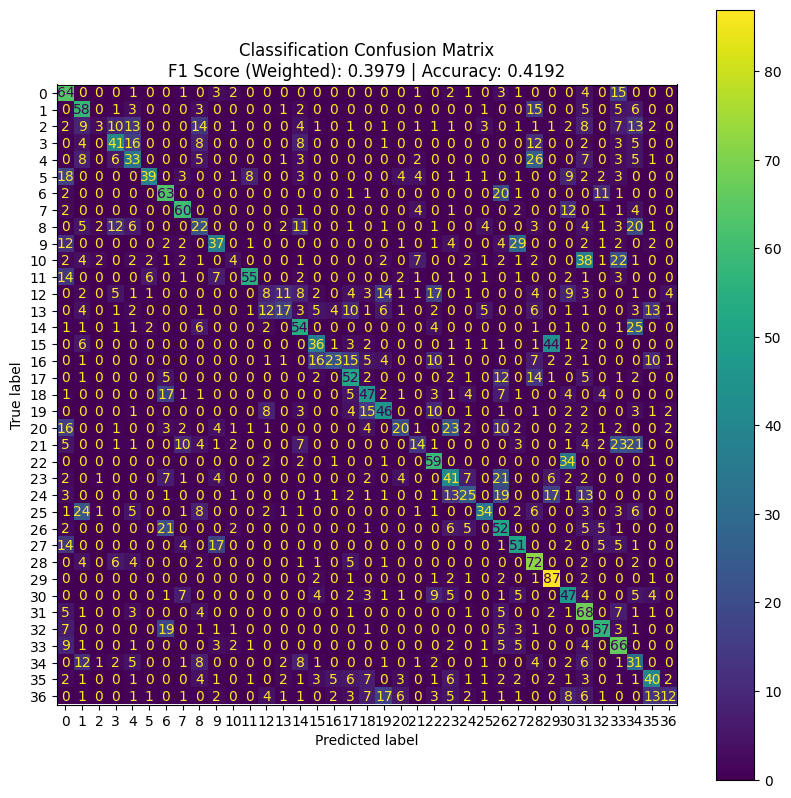

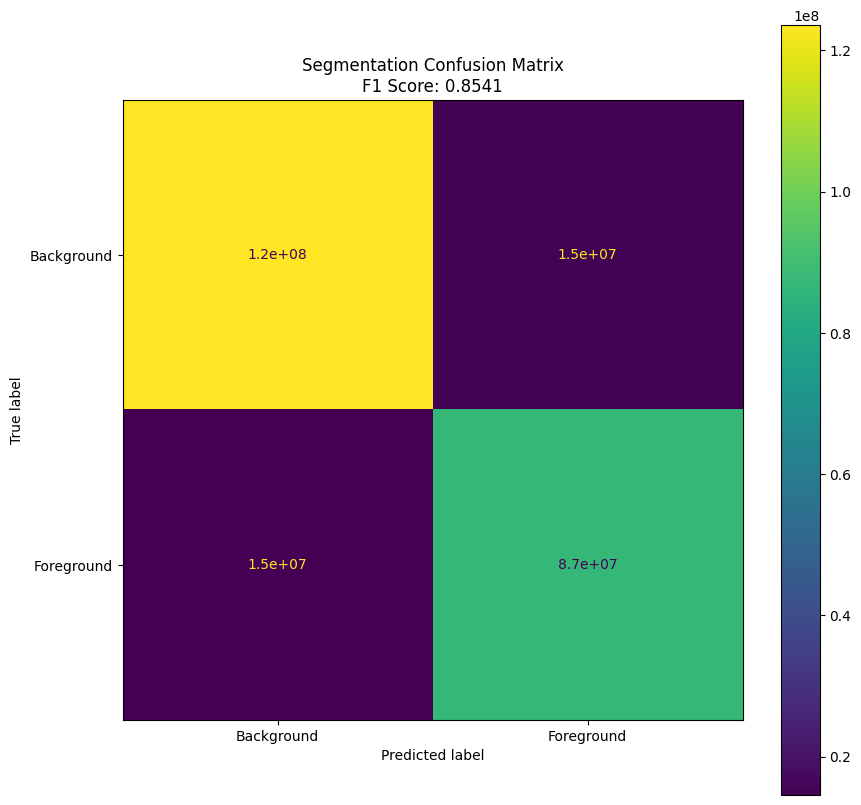

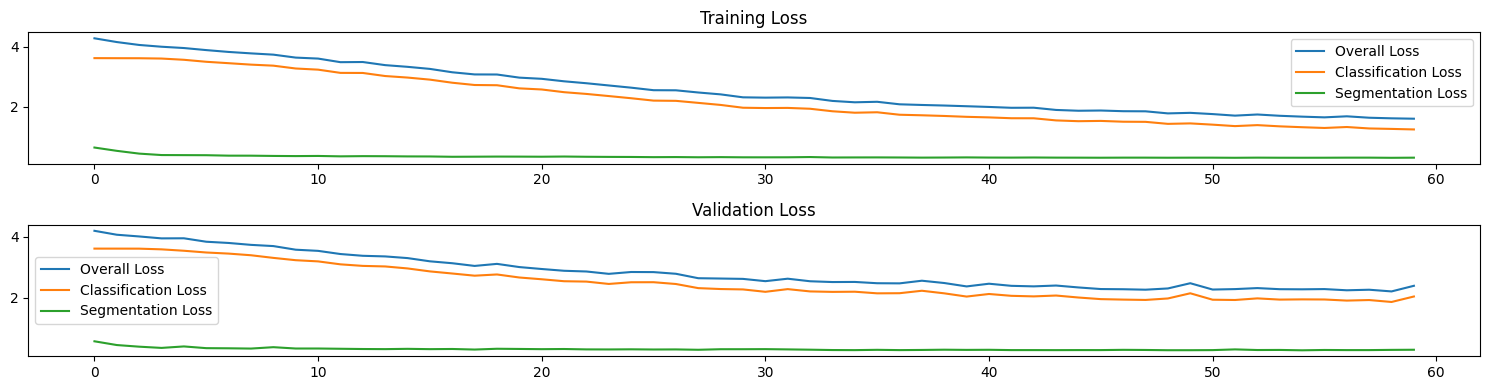

In [11]:
def eval_models(model, test_dataset, y_class_test, y_seg_test, history):
    # Predict class and segmentation outputs
    class_preds, seg_preds = model.predict(test_dataset)

    # Flatten segmentation predictions and ground truth
    seg_preds_flat = seg_preds.reshape(-1) > 0.5
    seg_gt_flat = y_seg_test.reshape(-1) > 0.5

    # Classification predictions
    class_preds_labels = np.argmax(class_preds, axis=-1)

    # Compute classification metrics
    cm_class = confusion_matrix(y_class_test, class_preds_labels)
    class_f1 = f1_score(y_class_test, class_preds_labels, average='weighted')
    class_accuracy = accuracy_score(y_class_test, class_preds_labels)

    # Confusion matrix for classification
    fig = plt.figure(figsize=[10, 10])
    ax = fig.add_subplot(1, 1, 1)
    class_disp = ConfusionMatrixDisplay(cm_class, display_labels=range(37))
    class_disp.plot(ax=ax)
    ax.set_title(f"Classification Confusion Matrix\nF1 Score (Weighted): {class_f1:.4f} | Accuracy: {class_accuracy:.4f}")

    # Segmentation confusion matrix
    cm_seg = confusion_matrix(seg_gt_flat, seg_preds_flat)
    seg_f1 = f1_score(seg_gt_flat, seg_preds_flat)
    fig = plt.figure(figsize=[10, 10])
    ax = fig.add_subplot(1, 1, 1)
    seg_disp = ConfusionMatrixDisplay(cm_seg, display_labels=["Background", "Foreground"])
    seg_disp.plot(ax=ax)
    ax.set_title(f"Segmentation Confusion Matrix\nF1 Score: {seg_f1:.4f}")

    # Classification report
    class_report_str = classification_report(y_class_test, class_preds_labels)
    print("\nClassification Report:\n", class_report_str)

    # Segmentation evaluation metrics
    seg_precision = precision_score(seg_gt_flat, seg_preds_flat)
    seg_recall = recall_score(seg_gt_flat, seg_preds_flat)
    seg_accuracy = accuracy_score(seg_gt_flat, seg_preds_flat)

    print("\nSegmentation Evaluation:")
    print("Precision:", seg_precision)
    print("Recall:", seg_recall)
    print("F1 Score:", seg_f1)
    print("Accuracy:", seg_accuracy)

    # Print available history keys
    print("\nAvailable History Keys:", history.history.keys())
# Available History Keys: dict_keys(['conv2d_5_binary_crossentropy', 'dense_1_sparse_categorical_crossentropy', 'loss', 'val_conv2d_5_binary_crossentropy', 'val_dense_1_sparse_categorical_crossentropy', 'val_loss'])
    # Training and Validation Loss Plots
    fig = plt.figure(figsize=[15, 4])
    ax1 = fig.add_subplot(2, 1, 1)
    ax1.plot(history.history['loss'], label='Overall Loss')
    ax1.plot(history.history['dense_2_sparse_categorical_crossentropy'], label='Classification Loss')
    ax1.plot(history.history['conv2d_5_binary_crossentropy'], label='Segmentation Loss')
    ax1.legend()
    ax1.set_title('Training Loss')

    ax2 = fig.add_subplot(2, 1, 2)
    ax2.plot(history.history['val_loss'], label='Overall Loss')
    ax2.plot(history.history['val_dense_2_sparse_categorical_crossentropy'], label='Classification Loss')
    ax2.plot(history.history['val_conv2d_5_binary_crossentropy'], label='Segmentation Loss')
    ax2.legend()
    ax2.set_title('Validation Loss')

    plt.tight_layout()
    plt.show()

# Usage
y_class_test = np.concatenate([y[0] for x, y in test_class_seg.as_numpy_iterator()])
y_seg_test = np.concatenate([y[1] for x, y in test_class_seg.as_numpy_iterator()])

eval_models(dcnn_model, test_class_seg, y_class_test, y_seg_test, history)


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


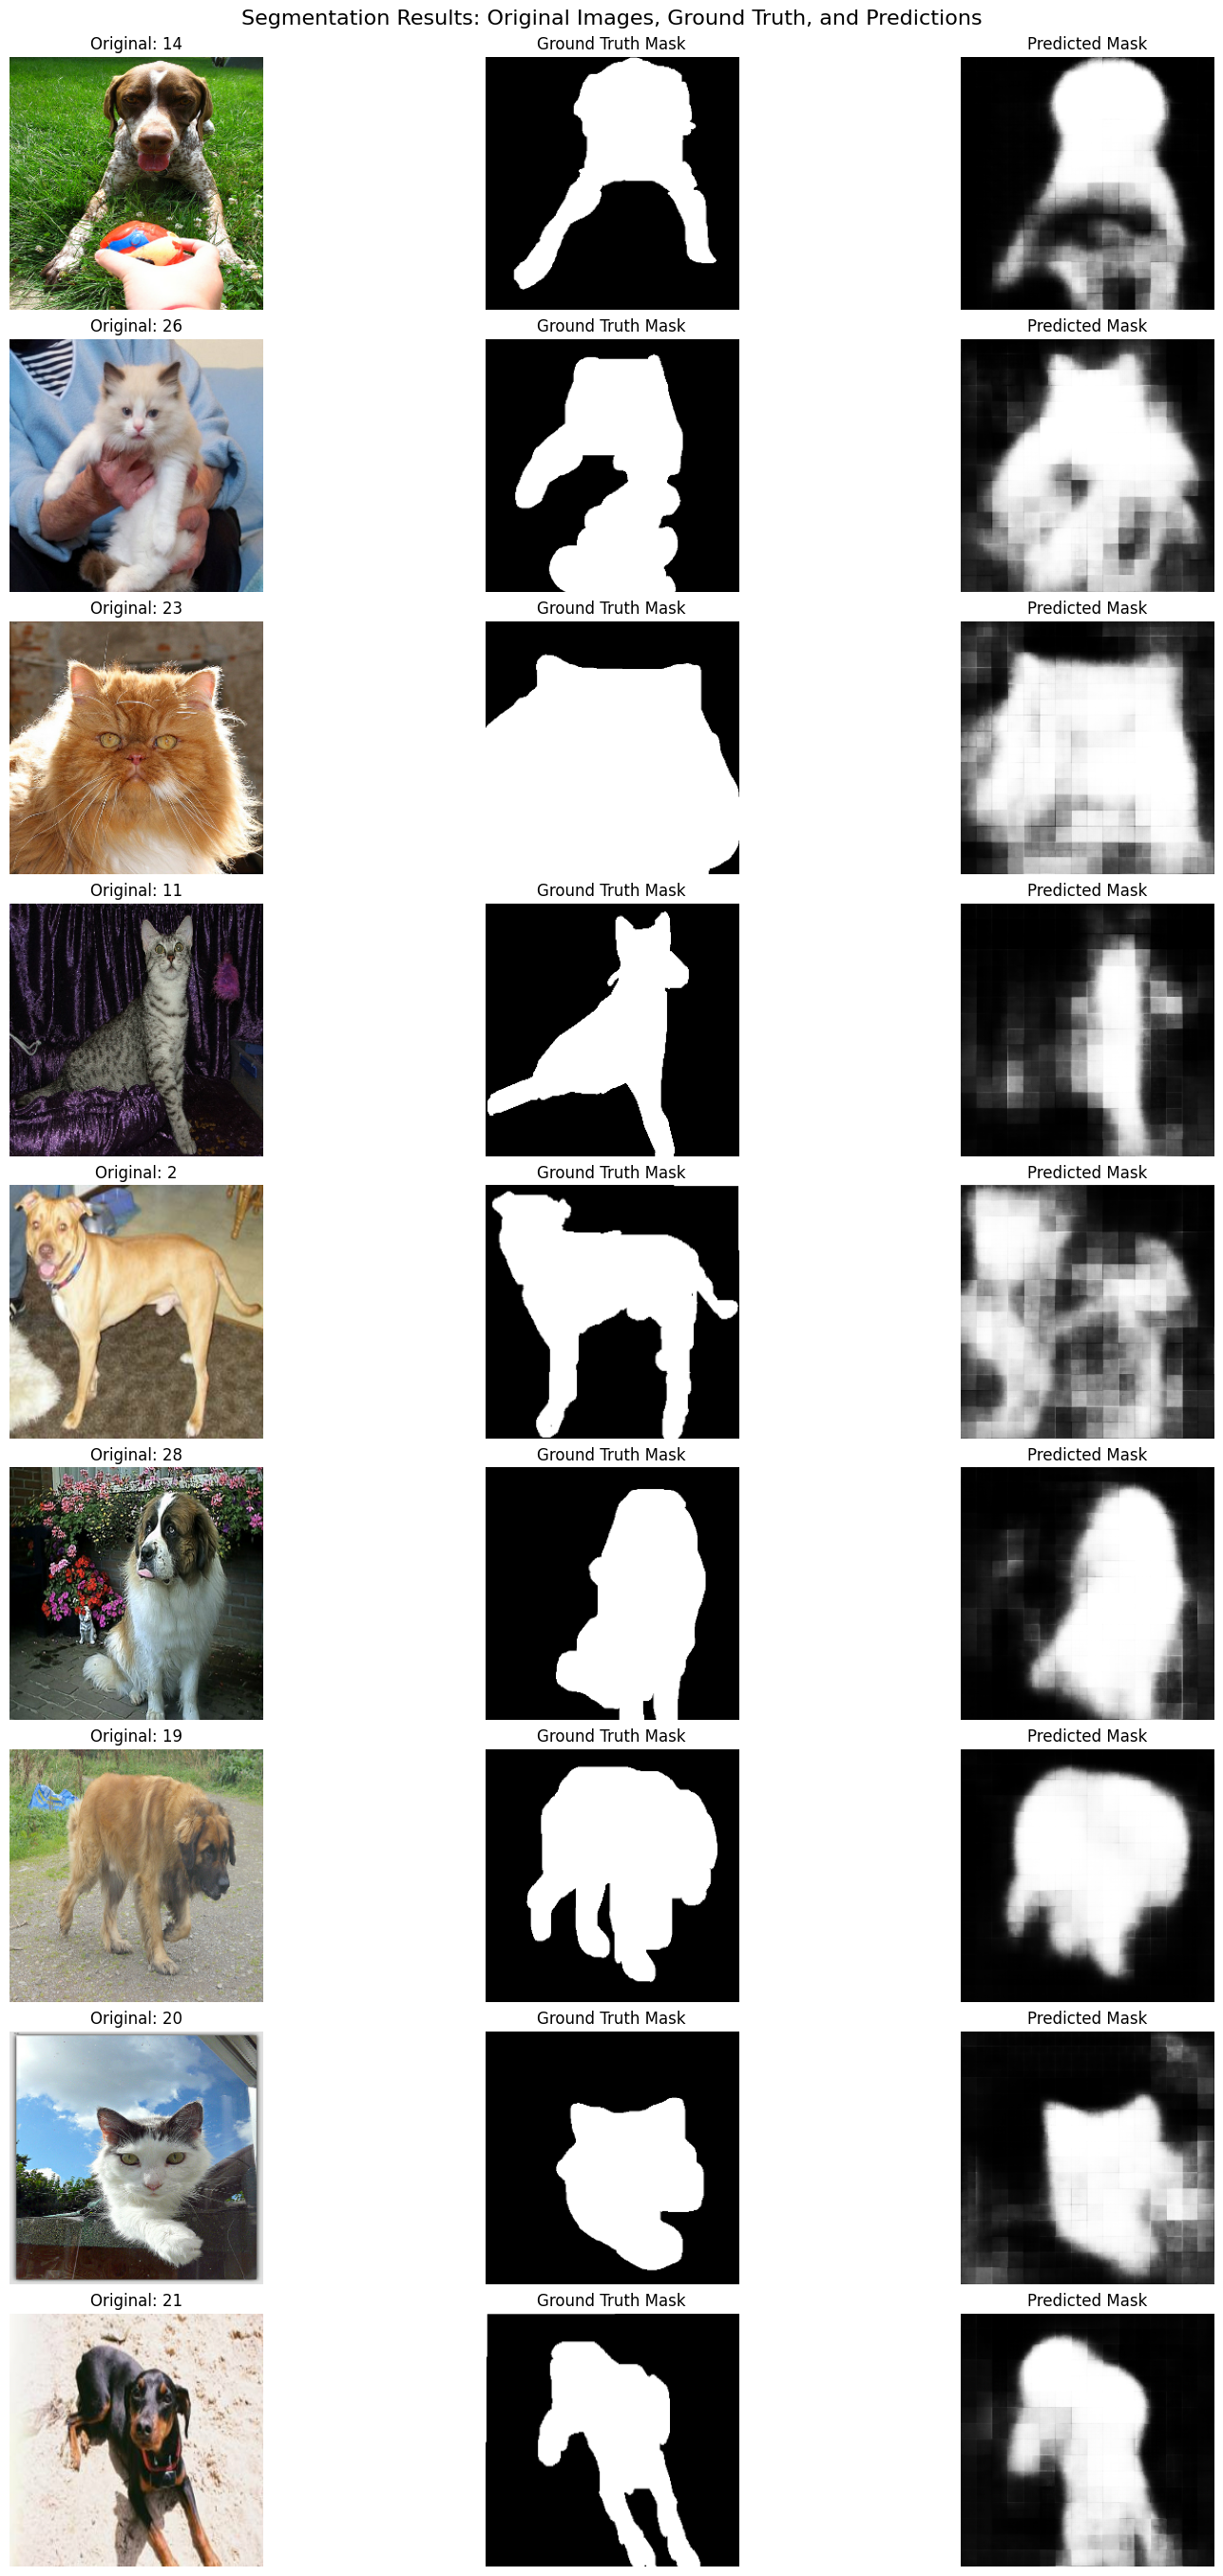

In [12]:
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score

# def plot_confusion_and_f1(y_true, y_pred, num_classes, title="Confusion Matrix"):
#     cm = confusion_matrix(y_true, y_pred)
#     f1 = f1_score(y_true, y_pred, average='weighted')
#     fig, ax = plt.subplots(figsize=(10, 10))
#     c = ConfusionMatrixDisplay(cm, display_labels=range(num_classes))
#     c.plot(ax=ax)
#     ax.set_title(f"{title}\nF1 Score: {f1:.4f}")
#     plt.show()

#     print(classification_report(y_true, y_pred))


# def plot_segmentation(test_data, test_classification_predictions, test_segmentation_predictions, test_predicted_labels, num_samples=27, grid_size=(3, 9)):
#     num_rows = num_plot // 3
#     fig, ax = plt.subplots(num_rows, 9, figsize=(15, num_rows * 3), constrained_layout=True)
#     fig, ax = plt.subplots(grid_size[0], grid_size[1], figsize=(18, 10))
#     ax = ax.flatten()

#     for i in range(num_samples):
#         sample_image, sample_output = next(iter(test_data))
#         sample_label, sample_mask = sample_output

#         ax[i].imshow(sample_image[i].numpy().astype('uint8'))
#         ax[i].contour(sample_mask[i, :, :, 0], colors='red', levels=[0.5])
#         ax[i].contour(test_segmentation_predictions[i, :, :, 0], colors='green', levels=[0.5])
#         ax[i].set_title(f'Ground Truth: {sample_label[i]} / Predicted: {test_predicted_labels[i]}')
#         ax[i].axis('off')
        
#     for j in range(num_samples, len(ax)):
#         ax[j].axis('off')

#     fig.suptitle("Segmentation Example (Ground Truth in Red, Prediction in Green)")
#     plt.show()

# Evaluation function
# def eval_multitask_models(model, train_data, test_data, num_classes, history):
#     # Predictions on training data
#     train_predictions = model.predict(train_data)
#     train_classification_predictions, _ = train_predictions
#     train_ground_truth_labels = []

#     for _, (label, _) in train_data:
#         train_ground_truth_labels.extend(label.numpy())

#     train_predicted_labels = np.argmax(train_classification_predictions, axis=1)
#     plot_confusion_and_f1(train_ground_truth_labels, train_predicted_labels, num_classes, "Training Confusion Matrix")

#     # Predictions on test data
#     test_predictions = model.predict(test_data)
#     test_classification_predictions, test_segmentation_predictions = test_predictions
#     test_ground_truth_labels, test_ground_truth_masks = [], []

#     for _, (label, mask) in test_data:
#         test_ground_truth_labels.extend(label.numpy())
#         test_ground_truth_masks.extend(mask.numpy())

#     # Test Confusion Matrix
#     test_predicted_labels = np.argmax(test_classification_predictions, axis=1)
#     plot_confusion_and_f1(test_ground_truth_labels, test_predicted_labels, num_classes, "Testing Confusion Matrix")
    

#     # Check available history keys for metrics plotting
#     print(f"Available keys in history: {history.history.keys()}")

#     # Plot Training and Validation Loss and Accuracy
#     # Training and Validation Loss Plots
#     fig = plt.figure(figsize=[15, 8])
#     ax1 = fig.add_subplot(2, 1, 1)
#     ax1.plot(history.history['loss'], label='Overall Loss')
#     ax1.plot(history.history['dense_3_sparse_categorical_crossentropy'], label='Classification Accuracy')
#     ax1.plot(history.history['conv2d_11_binary_crossentropy'], label='Segmentation Accuracy')
#     ax1.legend()
#     ax1.set_title('Training Loss and Accuracy')

#     ax2 = fig.add_subplot(2, 1, 2)
#     ax2.plot(history.history['val_loss'], label='Overall Loss')
#     ax2.plot(history.history['val_dense_3_sparse_categorical_crossentropy'], label='Classification Accuracy')
#     ax2.plot(history.history['val_conv2d_11_binary_crossentropy'], label='Segmentation Accuracy')
#     ax2.legend()
#     ax2.set_title('Validation Loss and Accuracy')
    
#     plt.show()

    # # Example Segmentation Visualization
    # fig, ax = plt.subplots(1, 27, figsize=(15, 5))
    # plot_segmentation(
    # test_data=test_class_seg,
    # test_classification_predictions=test_classification_predictions,
    # test_segmentation_predictions=test_segmentation_predictions,
    # test_predicted_labels=test_predicted_labels,
    # num_samples=27,
    # grid_size=(3, 9)
    # )

    # fig.suptitle("Segmentation Example (Ground Truth in Red, Prediction in Green)")
    # plt.show()


# eval_multitask_models(dcnn_model, train_class_seg, test_class_seg, num_classes=37, history=history)

# Function to unprocess the images
def unprocess_image(image):
    image = image * 255.0 + 127.5
    return image

# Plotting Function with Dynamic Prediction
def plot_segmentation_results_with_predictions(model, dataset, num_plot=27, image_size=256):
    num_rows = (num_plot + 2) // 3
    fig, axs = plt.subplots(num_rows, 3, figsize=(15, num_rows * 3), constrained_layout=True)

    row_idx = 0

    for image, output in dataset.take(1).as_numpy_iterator():
        # Predict for the same batch
        predictions = model.predict(image)[1]

        for i in range(num_plot):
            col_idx = i % 3
            row_idx = i // 3

            if col_idx == 0:
                # Original Image
                axs[row_idx, col_idx].imshow(np.squeeze(unprocess_image(image[row_idx, ...])) / 255.0)
                axs[row_idx, col_idx].set_title(f"Original: {output[0][row_idx]}")
                axs[row_idx, col_idx].axis('off')

            elif col_idx == 1:
                # Ground Truth Segmentation Mask
                axs[row_idx, col_idx].imshow(np.squeeze(output[1][row_idx, ...]), cmap='gray')
                axs[row_idx, col_idx].set_title("Ground Truth Mask")
                axs[row_idx, col_idx].axis('off')

            elif col_idx == 2:
                # Predicted Segmentation Mask
                axs[row_idx, col_idx].imshow(np.squeeze(predictions[row_idx, :, :, 0]), cmap='gray')
                axs[row_idx, col_idx].set_title("Predicted Mask")
                axs[row_idx, col_idx].axis('off')

    # Turn off extra subplots
    for i in range(num_plot, num_rows * 3):
        axs.flatten()[i].axis('off')

    fig.suptitle("Segmentation Results: Original Images, Ground Truth, and Predictions", fontsize=16)
    plt.show()

# Example Usage
plot_segmentation_results_with_predictions(dcnn_model, train_class_seg, num_plot=27, image_size=image_size)

In [27]:
#
# Fine-tuned MobileNet
#
# Pur your mobilenet model here. This will have the same structure as the from-scratch network above, but now the backbone will be mobilenet rather
# than something of your own design. The classification and segmentation heads will possibly be quite similar to what you have above. As per the 
# from-scratch network, you may want to build this with just one output to start with, and then add the second when you get that working.

# load mobilenet backbone
mobile_base = keras.applications.MobileNetV3Small(input_shape=(image_size, image_size, 3),
                                                  include_top=False,
                                                  include_preprocessing=False)
# build the rest of the model here

# train the model. As per the from-scratch model, you may wish to use the callback - though if the model is not trained until convergence you will
# need to explain the implications of this.

/home/imhaom/.local/lib/python3.11/site-packages/keras/src/applications/mobilenet_v3.py:449: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


In [28]:
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras import Model
import tensorflow as tf

# Function to build MobileNetV3Small model with classification and segmentation heads
def build_fine_tuned_mobilenet_model(image_size=256, num_classes=37):
    mobile_base = MobileNetV3Small(
        input_shape=(image_size, image_size, 3),
        include_top=False,
        include_preprocessing=False,
        weights='imagenet'
    )
    mobile_base.trainable = False  # Freeze the pre-trained layers

    input_img = mobile_base.input
    backbone_output = mobile_base.output

    # Classification Head
    classification_head = GlobalAveragePooling2D()(backbone_output)
    classification_head = Dense(256, activation='relu')(classification_head)
    classification_head = Dropout(0.4)(classification_head)
    classification_head = Dense(num_classes, activation='softmax', dtype='float32')(classification_head)

    # Segmentation Head
    segmentation_head = Conv2DTranspose(512, (3, 3), strides=(2, 2), activation='relu', padding='same')(backbone_output)
    segmentation_head = Conv2DTranspose(256, (3, 3), strides=(2, 2), activation='relu', padding='same')(segmentation_head)
    segmentation_head = Conv2DTranspose(128, (3, 3), strides=(2, 2), activation='relu', padding='same')(segmentation_head)
    segmentation_head = Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu', padding='same')(segmentation_head)
    segmentation_head = Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='relu', padding='same')(segmentation_head)
    segmentation_head = Conv2D(1, (1, 1), activation='sigmoid', padding='same', dtype='float32')(segmentation_head)

    model = Model(inputs=input_img, outputs=[classification_head, segmentation_head])
    model.mobile_base = mobile_base  # Save the base model as an attribute for later access
    return model

# Instantiate the fine-tuned MobileNetV3Small model
fine_tuned_mobilenet_model = build_fine_tuned_mobilenet_model(image_size=image_size, num_classes=37)

# Compile the fine-tuned MobileNetV3Small model
fine_tuned_mobilenet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=[tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 'binary_crossentropy'],
    metrics=[tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 'binary_crossentropy']
)


# Training with frozen layers for 50 epochs
# checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     'checkpoint_epoch_{epoch:02d}.weights.h5',
#     # save_best_only=True,
#     save_weights_only=True,
#     monitor='val_loss',
#     verbose=1
# )
history_fine_tuned_mobilenet = fine_tuned_mobilenet_model.fit(
    train_class_seg,
    epochs=30,
    verbose=1,
    validation_data=test_class_seg,
    # callbacks=[checkpoint_callback]
)

print("\nAvailable History Keys:", history_fine_tuned_mobilenet.history.keys())


Epoch 1/30


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 19s 85ms/step - conv2d_7_binary_crossentropy: 0.4463 - dense_8_sparse_categorical_crossentropy: 2.8169 - loss: 3.2632 - val_conv2d_7_binary_crossentropy: 0.2009 - val_dense_8_sparse_categorical_crossentropy: 0.7576 - val_loss: 0.9585
Epoch 2/30


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - conv2d_7_binary_crossentropy: 0.1918 - dense_8_sparse_categorical_crossentropy: 0.9389 - loss: 1.1308 - val_conv2d_7_binary_crossentropy: 0.1892 - val_dense_8_sparse_categorical_crossentropy: 0.6094 - val_loss: 0.7986
Epoch 3/30


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - conv2d_7_binary_crossentropy: 0.1754 - dense_8_sparse_categorical_crossentropy: 0.6936 - loss: 0.8690 - val_conv2d_7_binary_crossentropy: 0.1861 - val_dense_8_sparse_categorical_crossentropy: 0.5370 - val_loss: 0.7230
Epoch 4/30


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - conv2d_7_binary_crossentropy: 0.1584 - dense_8_sparse_categorical_crossentropy: 0.5287 - loss: 0.6871 - val_conv2d_7_binary_crossentropy: 0.1840 - val_dense_8_sparse_categorical_crossentropy: 0.5088 - val_loss: 0.6928
Epoch 5/30


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - conv2d_7_binary_crossentropy: 0.1483 - dense_8_sparse_categorical_crossentropy: 0.4488 - loss: 0.5971 - val_conv2d_7_binary_crossentropy: 0.1885 - val_dense_8_sparse_categorical_crossentropy: 0.5162 - val_loss: 0.7047
Epoch 6/30


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - conv2d_7_binary_crossentropy: 0.1372 - dense_8_sparse_categorical_crossentropy: 0.3633 - loss: 0.5005 - val_conv2d_7_binary_crossentropy: 0.1895 - val_dense_8_sparse_categorical_crossentropy: 0.4997 - val_loss: 0.6891
Epoch 7/30


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - conv2d_7_binary_crossentropy: 0.1250 - dense_8_sparse_categorical_crossentropy: 0.3150 - loss: 0.4400 - val_conv2d_7_binary_crossentropy: 0.2053 - val_dense_8_sparse_categorical_crossentropy: 0.5633 - val_loss: 0.7686
Epoch 8/30


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - conv2d_7_binary_crossentropy: 0.1155 - dense_8_sparse_categorical_crossentropy: 0.2908 - loss: 0.4063 - val_conv2d_7_binary_crossentropy: 0.2031 - val_dense_8_sparse_categorical_crossentropy: 0.5410 - val_loss: 0.7441
Epoch 9/30


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - conv2d_7_binary_crossentropy: 0.1062 - dense_8_sparse_categorical_crossentropy: 0.2528 - loss: 0.3591 - val_conv2d_7_binary_crossentropy: 0.2206 - val_dense_8_sparse_categorical_crossentropy: 0.5582 - val_loss: 0.7789
Epoch 10/30


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - conv2d_7_binary_crossentropy: 0.0994 - dense_8_sparse_categorical_crossentropy: 0.2357 - loss: 0.3351 - val_conv2d_7_binary_crossentropy: 0.2210 - val_dense_8_sparse_categorical_crossentropy: 0.5620 - val_loss: 0.7830
Epoch 11/30


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - conv2d_7_binary_crossentropy: 0.0913 - dense_8_sparse_categorical_crossentropy: 0.2212 - loss: 0.3124 - val_conv2d_7_binary_crossentropy: 0.2371 - val_dense_8_sparse_categorical_crossentropy: 0.5379 - val_loss: 0.7750
Epoch 12/30


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - conv2d_7_binary_crossentropy: 0.0883 - dense_8_sparse_categorical_crossentropy: 0.1842 - loss: 0.2725 - val_conv2d_7_binary_crossentropy: 0.2399 - val_dense_8_sparse_categorical_crossentropy: 0.5892 - val_loss: 0.8291
Epoch 13/30


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - conv2d_7_binary_crossentropy: 0.0825 - dense_8_sparse_categorical_crossentropy: 0.1694 - loss: 0.2519 - val_conv2d_7_binary_crossentropy: 0.2510 - val_dense_8_sparse_categorical_crossentropy: 0.5510 - val_loss: 0.8021
Epoch 14/30


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - conv2d_7_binary_crossentropy: 0.0769 - dense_8_sparse_categorical_crossentropy: 0.1282 - loss: 0.2051 - val_conv2d_7_binary_crossentropy: 0.2636 - val_dense_8_sparse_categorical_crossentropy: 0.5934 - val_loss: 0.8570
Epoch 15/30


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - conv2d_7_binary_crossentropy: 0.0729 - dense_8_sparse_categorical_crossentropy: 0.1590 - loss: 0.2319 - val_conv2d_7_binary_crossentropy: 0.2703 - val_dense_8_sparse_categorical_crossentropy: 0.5981 - val_loss: 0.8685
Epoch 16/30


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - conv2d_7_binary_crossentropy: 0.0686 - dense_8_sparse_categorical_crossentropy: 0.1465 - loss: 0.2151 - val_conv2d_7_binary_crossentropy: 0.2850 - val_dense_8_sparse_categorical_crossentropy: 0.6072 - val_loss: 0.8922
Epoch 17/30


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - conv2d_7_binary_crossentropy: 0.0653 - dense_8_sparse_categorical_crossentropy: 0.1252 - loss: 0.1906 - val_conv2d_7_binary_crossentropy: 0.2892 - val_dense_8_sparse_categorical_crossentropy: 0.6402 - val_loss: 0.9294
Epoch 18/30


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - conv2d_7_binary_crossentropy: 0.0618 - dense_8_sparse_categorical_crossentropy: 0.1017 - loss: 0.1635 - val_conv2d_7_binary_crossentropy: 0.3022 - val_dense_8_sparse_categorical_crossentropy: 0.6036 - val_loss: 0.9058
Epoch 19/30


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - conv2d_7_binary_crossentropy: 0.0589 - dense_8_sparse_categorical_crossentropy: 0.1148 - loss: 0.1738 - val_conv2d_7_binary_crossentropy: 0.3133 - val_dense_8_sparse_categorical_crossentropy: 0.6227 - val_loss: 0.9359
Epoch 20/30


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - conv2d_7_binary_crossentropy: 0.0565 - dense_8_sparse_categorical_crossentropy: 0.1321 - loss: 0.1886 - val_conv2d_7_binary_crossentropy: 0.3122 - val_dense_8_sparse_categorical_crossentropy: 0.6191 - val_loss: 0.9314
Epoch 21/30


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - conv2d_7_binary_crossentropy: 0.0540 - dense_8_sparse_categorical_crossentropy: 0.1053 - loss: 0.1593 - val_conv2d_7_binary_crossentropy: 0.3182 - val_dense_8_sparse_categorical_crossentropy: 0.6254 - val_loss: 0.9436
Epoch 22/30


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - conv2d_7_binary_crossentropy: 0.0515 - dense_8_sparse_categorical_crossentropy: 0.0939 - loss: 0.1454 - val_conv2d_7_binary_crossentropy: 0.3343 - val_dense_8_sparse_categorical_crossentropy: 0.7292 - val_loss: 1.0635
Epoch 23/30


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - conv2d_7_binary_crossentropy: 0.0500 - dense_8_sparse_categorical_crossentropy: 0.0973 - loss: 0.1473 - val_conv2d_7_binary_crossentropy: 0.3423 - val_dense_8_sparse_categorical_crossentropy: 0.6550 - val_loss: 0.9972
Epoch 24/30


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - conv2d_7_binary_crossentropy: 0.0481 - dense_8_sparse_categorical_crossentropy: 0.0971 - loss: 0.1452 - val_conv2d_7_binary_crossentropy: 0.3554 - val_dense_8_sparse_categorical_crossentropy: 0.6291 - val_loss: 0.9845
Epoch 25/30


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - conv2d_7_binary_crossentropy: 0.0468 - dense_8_sparse_categorical_crossentropy: 0.0653 - loss: 0.1121 - val_conv2d_7_binary_crossentropy: 0.3553 - val_dense_8_sparse_categorical_crossentropy: 0.6712 - val_loss: 1.0264
Epoch 26/30


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - conv2d_7_binary_crossentropy: 0.0453 - dense_8_sparse_categorical_crossentropy: 0.0846 - loss: 0.1299 - val_conv2d_7_binary_crossentropy: 0.3629 - val_dense_8_sparse_categorical_crossentropy: 0.7387 - val_loss: 1.1017
Epoch 27/30


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - conv2d_7_binary_crossentropy: 0.0433 - dense_8_sparse_categorical_crossentropy: 0.0866 - loss: 0.1299 - val_conv2d_7_binary_crossentropy: 0.3850 - val_dense_8_sparse_categorical_crossentropy: 0.8304 - val_loss: 1.2154
Epoch 28/30


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - conv2d_7_binary_crossentropy: 0.0430 - dense_8_sparse_categorical_crossentropy: 0.0981 - loss: 0.1412 - val_conv2d_7_binary_crossentropy: 0.3837 - val_dense_8_sparse_categorical_crossentropy: 0.7624 - val_loss: 1.1461
Epoch 29/30


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - conv2d_7_binary_crossentropy: 0.0416 - dense_8_sparse_categorical_crossentropy: 0.0674 - loss: 0.1090 - val_conv2d_7_binary_crossentropy: 0.4021 - val_dense_8_sparse_categorical_crossentropy: 0.7367 - val_loss: 1.1388
Epoch 30/30


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - conv2d_7_binary_crossentropy: 0.0402 - dense_8_sparse_categorical_crossentropy: 0.0877 - loss: 0.1278 - val_conv2d_7_binary_crossentropy: 0.4019 - val_dense_8_sparse_categorical_crossentropy: 0.7539 - val_loss: 1.1558

Available History Keys: dict_keys(['conv2d_7_binary_crossentropy', 'dense_8_sparse_categorical_crossentropy', 'loss', 'val_conv2d_7_binary_crossentropy', 'val_dense_8_sparse_categorical_crossentropy', 'val_loss'])


115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step

Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.89      0.76        98
           1       0.61      0.84      0.71       100
           2       0.71      0.52      0.60       100
           3       0.82      0.84      0.83       100
           4       0.70      0.87      0.78       100
           5       0.77      0.94      0.85       100
           6       0.69      0.82      0.75       100
           7       0.92      0.86      0.89        88
           8       0.77      0.80      0.79        99
           9       0.77      0.72      0.75       100
          10       0.84      0.69      0.76       100
          11       0.96      0.76      0.85        97
          12       0.93      0.74      0.82       100
          13       0.79      0.88      0.83       100
          14       0.91      0.95      0.93       100
          15       0.96      0.88      0.92       100
          16  

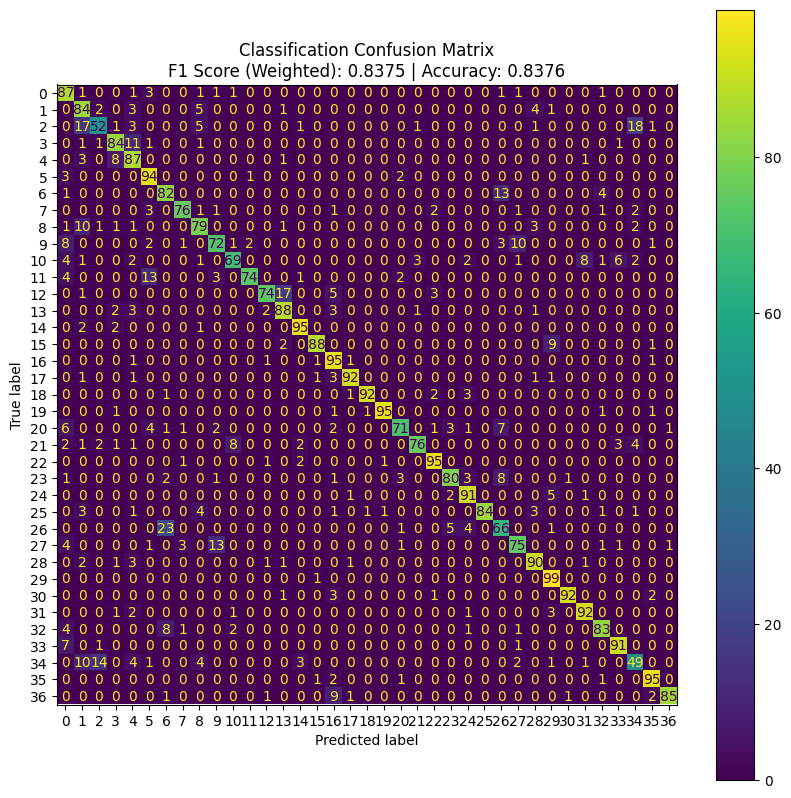

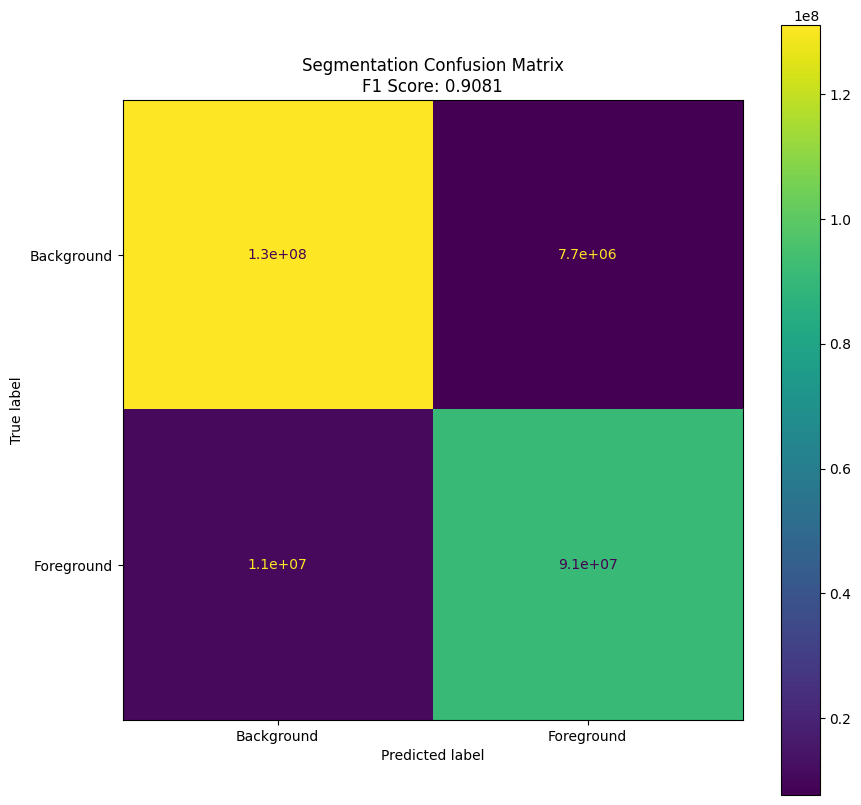

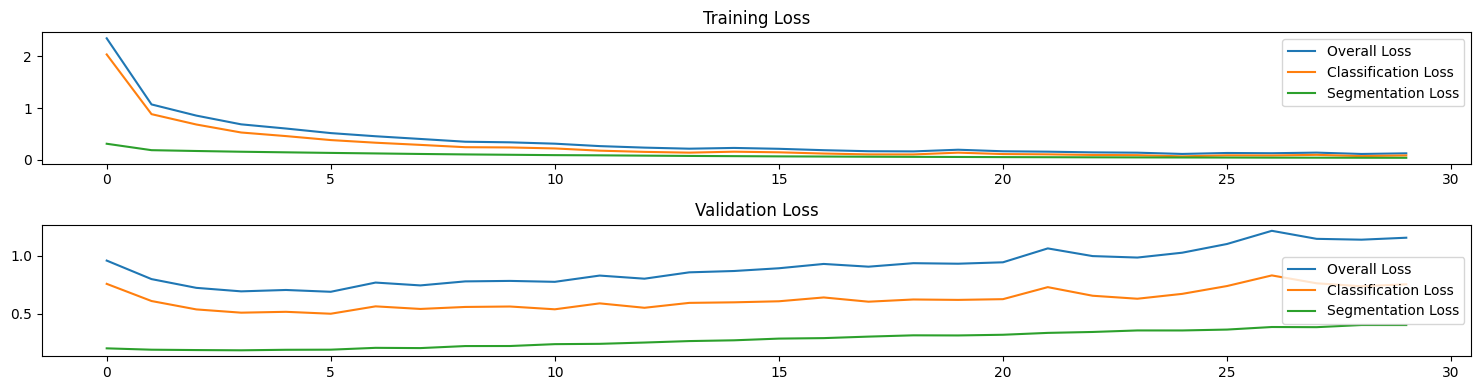

In [29]:
# Evaluation function
def eval_models(model, test_dataset, y_class_test, y_seg_test, history):
    class_preds, seg_preds = model.predict(test_dataset)

    # Segmentation Evaluation
    seg_preds_flat = seg_preds.reshape(-1) > 0.5
    seg_gt_flat = y_seg_test.reshape(-1) > 0.5

    class_preds_labels = np.argmax(class_preds, axis=-1)

    cm_class = confusion_matrix(y_class_test, class_preds_labels)
    class_f1 = f1_score(y_class_test, class_preds_labels, average='weighted')
    class_accuracy = accuracy_score(y_class_test, class_preds_labels)

    # Classification Confusion Matrix
    fig = plt.figure(figsize=[10, 10])
    ax = fig.add_subplot(1, 1, 1)
    class_disp = ConfusionMatrixDisplay(cm_class, display_labels=range(37))
    class_disp.plot(ax=ax)
    ax.set_title(f"Classification Confusion Matrix\nF1 Score (Weighted): {class_f1:.4f} | Accuracy: {class_accuracy:.4f}")

    # Segmentation Confusion Matrix
    cm_seg = confusion_matrix(seg_gt_flat, seg_preds_flat)
    seg_f1 = f1_score(seg_gt_flat, seg_preds_flat)
    fig = plt.figure(figsize=[10, 10])
    ax = fig.add_subplot(1, 1, 1)
    seg_disp = ConfusionMatrixDisplay(cm_seg, display_labels=["Background", "Foreground"])
    seg_disp.plot(ax=ax)
    ax.set_title(f"Segmentation Confusion Matrix\nF1 Score: {seg_f1:.4f}")

    # Classification Report
    class_report_str = classification_report(y_class_test, class_preds_labels)
    print("\nClassification Report:\n", class_report_str)

    # Segmentation Evaluation Metrics
    seg_precision = precision_score(seg_gt_flat, seg_preds_flat)
    seg_recall = recall_score(seg_gt_flat, seg_preds_flat)
    seg_accuracy = accuracy_score(seg_gt_flat, seg_preds_flat)

    print("\nSegmentation Evaluation:")
    print("Precision:", seg_precision)
    print("Recall:", seg_recall)
    print("F1 Score:", seg_f1)
    print("Accuracy:", seg_accuracy)

    # Training and Validation Loss Plots
    fig = plt.figure(figsize=[15, 4])
    ax1 = fig.add_subplot(2, 1, 1)
    ax1.plot(history.history['loss'], label='Overall Loss')
    ax1.plot(history.history['dense_8_sparse_categorical_crossentropy'], label='Classification Loss')
    ax1.plot(history.history['conv2d_7_binary_crossentropy'], label='Segmentation Loss')
    ax1.legend()
    ax1.set_title('Training Loss')

    ax2 = fig.add_subplot(2, 1, 2)
    ax2.plot(history.history['val_loss'], label='Overall Loss')
    ax2.plot(history.history['val_dense_8_sparse_categorical_crossentropy'], label='Classification Loss')
    ax2.plot(history.history['val_conv2d_7_binary_crossentropy'], label='Segmentation Loss')
    ax2.legend()
    ax2.set_title('Validation Loss')

    plt.tight_layout()
    plt.show()

# Usage for Fine-Tuned Model
y_class_test = np.concatenate([y[0] for x, y in test_class_seg.as_numpy_iterator()])
y_seg_test = np.concatenate([y[1] for x, y in test_class_seg.as_numpy_iterator()])

eval_models(fine_tuned_mobilenet_model, test_class_seg, y_class_test, y_seg_test, history_fine_tuned_mobilenet)

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


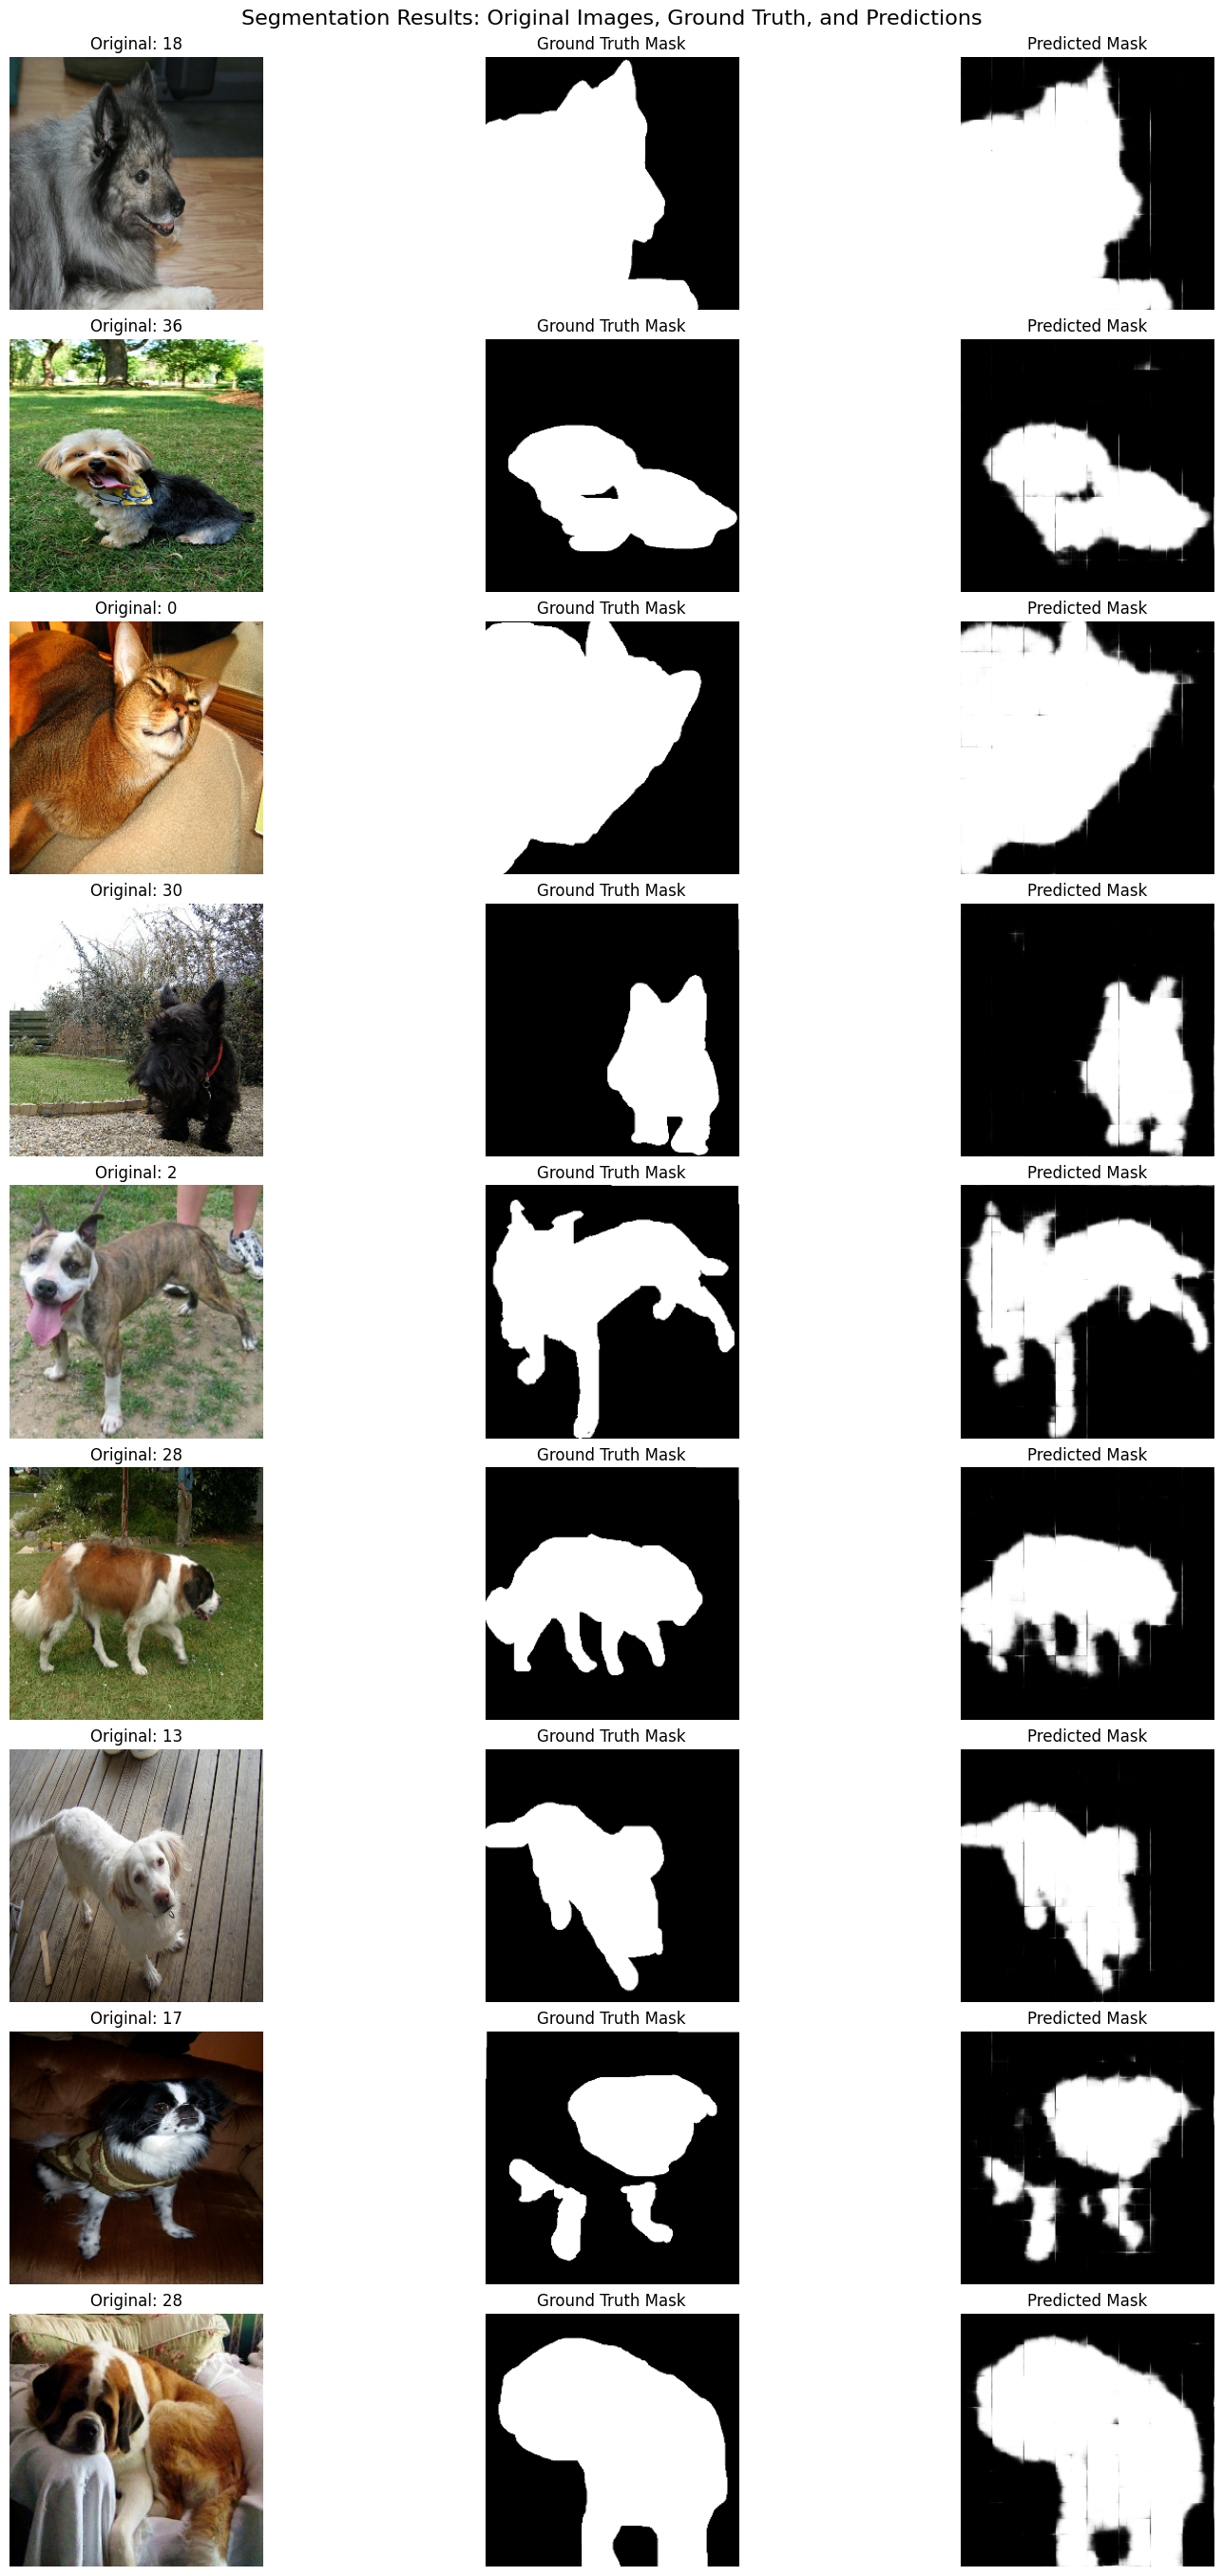

In [30]:
def unprocess_image(image):
    image = image * 255.0 + 127.5
    return image

# Plotting Function with Dynamic Prediction
def plot_segmentation_results_with_predictions(model, dataset, num_plot=27, image_size=256):
    num_rows = (num_plot + 2) // 3
    fig, axs = plt.subplots(num_rows, 3, figsize=(15, num_rows * 3), constrained_layout=True)

    row_idx = 0

    for image, output in dataset.take(1).as_numpy_iterator():
        # Predict for the same batch
        predictions = model.predict(image)[1]

        for i in range(num_plot):
            col_idx = i % 3
            row_idx = i // 3

            if col_idx == 0:
                # Original Image
                axs[row_idx, col_idx].imshow(np.squeeze(unprocess_image(image[row_idx, ...])) / 255.0)
                axs[row_idx, col_idx].set_title(f"Original: {output[0][row_idx]}")
                axs[row_idx, col_idx].axis('off')

            elif col_idx == 1:
                # Ground Truth Segmentation Mask
                axs[row_idx, col_idx].imshow(np.squeeze(output[1][row_idx, ...]), cmap='gray')
                axs[row_idx, col_idx].set_title("Ground Truth Mask")
                axs[row_idx, col_idx].axis('off')

            elif col_idx == 2:
                # Predicted Segmentation Mask
                axs[row_idx, col_idx].imshow(np.squeeze(predictions[row_idx, :, :, 0]), cmap='gray')
                axs[row_idx, col_idx].set_title("Predicted Mask")
                axs[row_idx, col_idx].axis('off')

    # Turn off extra subplots
    for i in range(num_plot, num_rows * 3):
        axs.flatten()[i].axis('off')

    fig.suptitle("Segmentation Results: Original Images, Ground Truth, and Predictions", fontsize=16)
    plt.show()

# Evaluate and visualize for the fine-tuned MobileNetV3Small model
# eval_multitask_models(fine_tuned_mobilenet_model, train_class_seg, test_class_seg, num_classes=37, history=history_fine_tuned_mobilenet)
plot_segmentation_results_with_predictions(fine_tuned_mobilenet_model, train_class_seg, num_plot=27, image_size=image_size)

In [37]:
# data_augmentation = tf.keras.Sequential([
#     tf.keras.layers.RandomRotation(0.05),
# ])

# # Apply the augmentations to the training dataset
# def augment(image, label):
#     image = data_augmentation(image, training=True)  # Ensure augmentations are active
#     return image, label

# # Assuming train_class_seg is a tf.data.Dataset
# train_class_seg_augmented = train_class_seg.map(augment)

# Unfreeze the last 10 layers
mobile_base = fine_tuned_mobilenet_model.mobile_base
for layer in mobile_base.layers[-10:]:
    layer.trainable = True
    
# Re-compile the model with a lower learning rate for fine-tuning
fine_tuned_mobilenet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=[tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 'binary_crossentropy'],
    metrics={
        'dense_8': 'sparse_categorical_crossentropy',
        'conv2d_7': 'binary_crossentropy'
    }
)

# Continue fine-tuning the model for another 50 epochs with the augmented dataset
history_fine_tuned_mobilenet_more = fine_tuned_mobilenet_model.fit(
    train_class_seg,  # Use the augmented training dataset
    epochs=10,
    verbose=1,
    validation_data=test_class_seg
)

Epoch 1/10


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 20s 86ms/step - conv2d_7_binary_crossentropy: 0.0690 - dense_8_sparse_categorical_crossentropy: 0.0114 - loss: 0.0804 - val_conv2d_7_binary_crossentropy: 0.3221 - val_dense_8_sparse_categorical_crossentropy: 0.8037 - val_loss: 1.1265
Epoch 2/10


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - conv2d_7_binary_crossentropy: 0.0448 - dense_8_sparse_categorical_crossentropy: 0.0132 - loss: 0.0581 - val_conv2d_7_binary_crossentropy: 0.3537 - val_dense_8_sparse_categorical_crossentropy: 0.8244 - val_loss: 1.1784
Epoch 3/10


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - conv2d_7_binary_crossentropy: 0.0413 - dense_8_sparse_categorical_crossentropy: 0.0129 - loss: 0.0543 - val_conv2d_7_binary_crossentropy: 0.3718 - val_dense_8_sparse_categorical_crossentropy: 0.8200 - val_loss: 1.1926
Epoch 4/10


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - conv2d_7_binary_crossentropy: 0.0398 - dense_8_sparse_categorical_crossentropy: 0.0158 - loss: 0.0556 - val_conv2d_7_binary_crossentropy: 0.3838 - val_dense_8_sparse_categorical_crossentropy: 0.8085 - val_loss: 1.1931
Epoch 5/10


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - conv2d_7_binary_crossentropy: 0.0386 - dense_8_sparse_categorical_crossentropy: 0.0116 - loss: 0.0502 - val_conv2d_7_binary_crossentropy: 0.3956 - val_dense_8_sparse_categorical_crossentropy: 0.8213 - val_loss: 1.2178
Epoch 6/10


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - conv2d_7_binary_crossentropy: 0.0374 - dense_8_sparse_categorical_crossentropy: 0.0081 - loss: 0.0455 - val_conv2d_7_binary_crossentropy: 0.3996 - val_dense_8_sparse_categorical_crossentropy: 0.8175 - val_loss: 1.2181
Epoch 7/10


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - conv2d_7_binary_crossentropy: 0.0365 - dense_8_sparse_categorical_crossentropy: 0.0113 - loss: 0.0478 - val_conv2d_7_binary_crossentropy: 0.4077 - val_dense_8_sparse_categorical_crossentropy: 0.8102 - val_loss: 1.2187
Epoch 8/10


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - conv2d_7_binary_crossentropy: 0.0358 - dense_8_sparse_categorical_crossentropy: 0.0108 - loss: 0.0466 - val_conv2d_7_binary_crossentropy: 0.4103 - val_dense_8_sparse_categorical_crossentropy: 0.8011 - val_loss: 1.2123
Epoch 9/10


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - conv2d_7_binary_crossentropy: 0.0356 - dense_8_sparse_categorical_crossentropy: 0.0113 - loss: 0.0469 - val_conv2d_7_binary_crossentropy: 0.4183 - val_dense_8_sparse_categorical_crossentropy: 0.8170 - val_loss: 1.2358
Epoch 10/10


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - conv2d_7_binary_crossentropy: 0.0348 - dense_8_sparse_categorical_crossentropy: 0.0076 - loss: 0.0424 - val_conv2d_7_binary_crossentropy: 0.4250 - val_dense_8_sparse_categorical_crossentropy: 0.8334 - val_loss: 1.2593


115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.87      0.85        98
           1       0.65      0.85      0.74       100
           2       0.75      0.45      0.56       100
           3       0.83      0.85      0.84       100
           4       0.78      0.82      0.80       100
           5       0.80      0.85      0.83       100
           6       0.74      0.69      0.72       100
           7       0.84      0.86      0.85        88
           8       0.71      0.80      0.75        99
           9       0.87      0.79      0.83       100
          10       0.78      0.65      0.71       100
          11       0.91      0.90      0.90        97
          12       0.86      0.85      0.85       100
          13       0.86      0.87      0.87       100
          14       0.91      0.93      0.92       100
          15       0.91      0.97      0.94       100
          16  

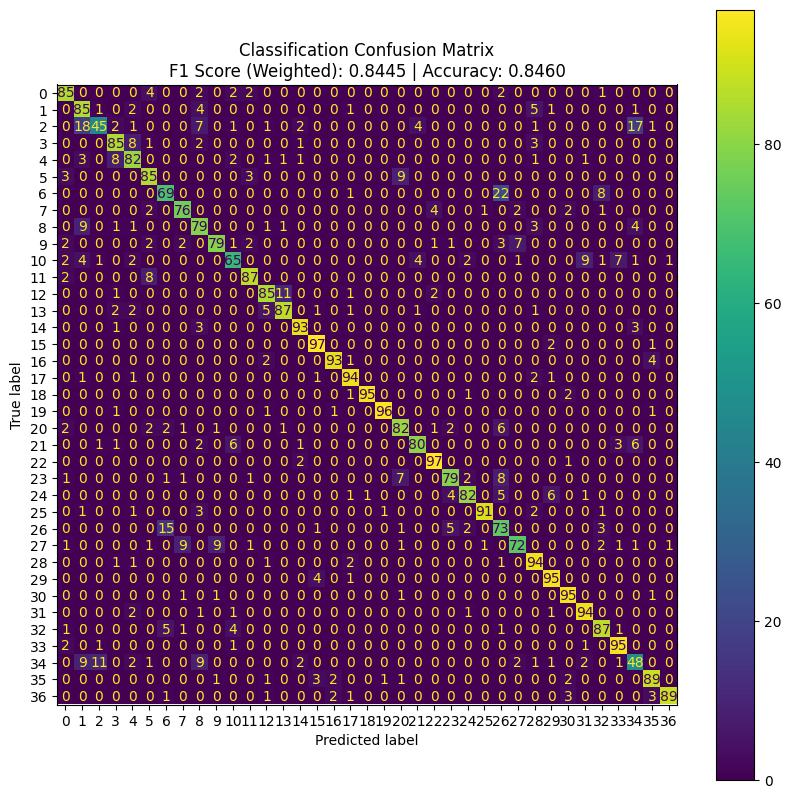

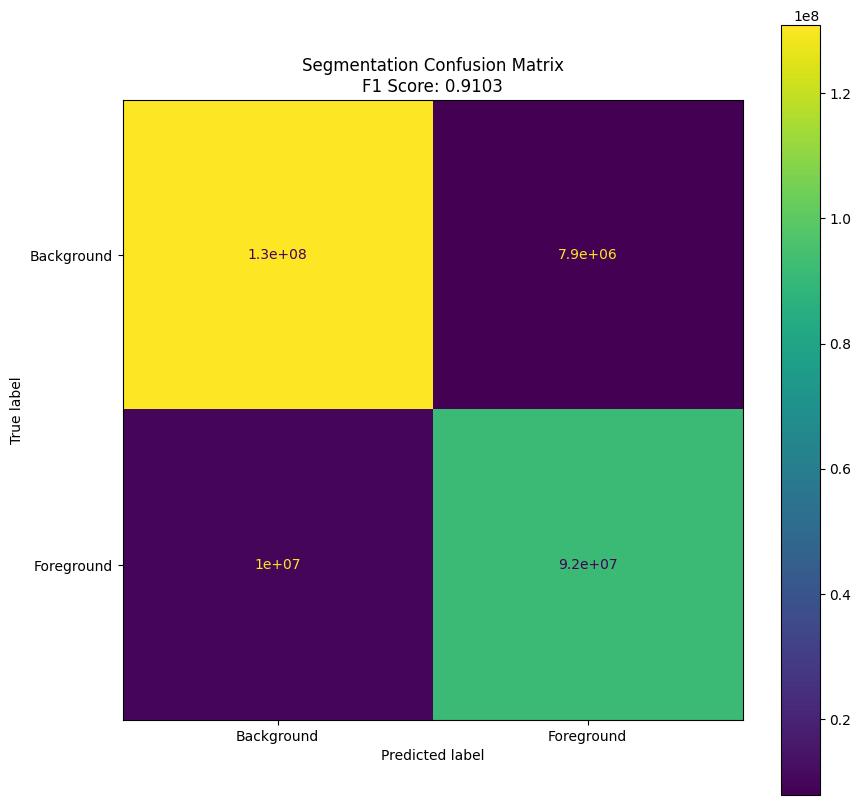

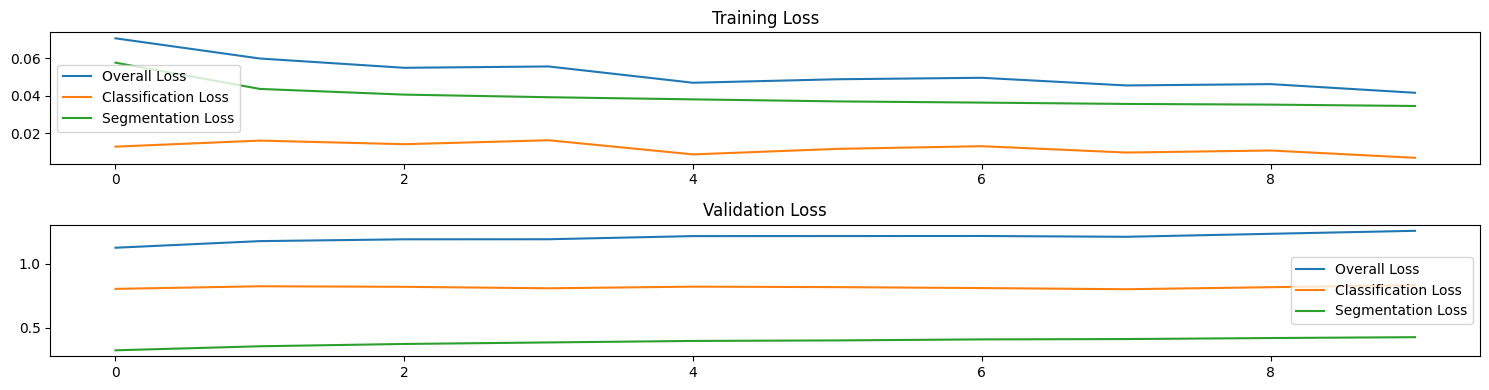

In [38]:
def eval_models_last(model, test_dataset, y_class_test, y_seg_test, history):
    # Predict class and segmentation outputs
    class_preds, seg_preds = model.predict(test_dataset)

    # Flatten segmentation predictions and ground truth
    seg_preds_flat = seg_preds.reshape(-1) > 0.5
    seg_gt_flat = y_seg_test.reshape(-1) > 0.5

    # Classification predictions
    class_preds_labels = np.argmax(class_preds, axis=-1)

    # Compute classification metrics
    cm_class = confusion_matrix(y_class_test, class_preds_labels)
    class_f1 = f1_score(y_class_test, class_preds_labels, average='weighted')
    class_accuracy = accuracy_score(y_class_test, class_preds_labels)

    # Confusion matrix for classification
    fig = plt.figure(figsize=[10, 10])
    ax = fig.add_subplot(1, 1, 1)
    class_disp = ConfusionMatrixDisplay(cm_class, display_labels=range(37))
    class_disp.plot(ax=ax)
    ax.set_title(f"Classification Confusion Matrix\nF1 Score (Weighted): {class_f1:.4f} | Accuracy: {class_accuracy:.4f}")

    # Segmentation confusion matrix
    cm_seg = confusion_matrix(seg_gt_flat, seg_preds_flat)
    seg_f1 = f1_score(seg_gt_flat, seg_preds_flat)
    fig = plt.figure(figsize=[10, 10])
    ax = fig.add_subplot(1, 1, 1)
    seg_disp = ConfusionMatrixDisplay(cm_seg, display_labels=["Background", "Foreground"])
    seg_disp.plot(ax=ax)
    ax.set_title(f"Segmentation Confusion Matrix\nF1 Score: {seg_f1:.4f}")

    # Classification report
    class_report_str = classification_report(y_class_test, class_preds_labels)
    print("\nClassification Report:\n", class_report_str)

    # Segmentation evaluation metrics
    seg_precision = precision_score(seg_gt_flat, seg_preds_flat)
    seg_recall = recall_score(seg_gt_flat, seg_preds_flat)
    seg_accuracy = accuracy_score(seg_gt_flat, seg_preds_flat)

    print("\nSegmentation Evaluation:")
    print("Precision:", seg_precision)
    print("Recall:", seg_recall)
    print("F1 Score:", seg_f1)
    print("Accuracy:", seg_accuracy)

    # Print available history keys
    print("\nAvailable History Keys:", history.history.keys())

    # Training and Validation Loss Plots
    fig = plt.figure(figsize=[15, 4])
    ax1 = fig.add_subplot(2, 1, 1)
    ax1.plot(history.history['loss'], label='Overall Loss')
    ax1.plot(history.history['dense_8_sparse_categorical_crossentropy'], label='Classification Loss')
    ax1.plot(history.history['conv2d_7_binary_crossentropy'], label='Segmentation Loss')
    ax1.legend()
    ax1.set_title('Training Loss')

    ax2 = fig.add_subplot(2, 1, 2)
    ax2.plot(history.history['val_loss'], label='Overall Loss')
    ax2.plot(history.history['val_dense_8_sparse_categorical_crossentropy'], label='Classification Loss')
    ax2.plot(history.history['val_conv2d_7_binary_crossentropy'], label='Segmentation Loss')
    ax2.legend()
    ax2.set_title('Validation Loss')

    plt.tight_layout()
    plt.show()
    
y_class_test = np.concatenate([y[0] for x, y in test_class_seg.as_numpy_iterator()])
y_seg_test = np.concatenate([y[1] for x, y in test_class_seg.as_numpy_iterator()])

eval_models_last(fine_tuned_mobilenet_model, test_class_seg, y_class_test, y_seg_test, history_fine_tuned_mobilenet_more)

In [19]:
fine_tuned_mobilenet_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 256, 256,  │       0 │ -                    │
│ (InputLayer)        │ 3)                │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv (Conv2D)       │ (None, 128, 128,  │     432 │ input_layer_3[0][0]  │
│                     │ 16)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv_bn             │ (None, 128, 128,  │      64 │ conv[0][0]           │
│ (BatchNormalizatio… │ 16)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ activation_36       │ (None, 128, 128,  │       0 │ conv_bn[0][0]        │
│ (Activation)        │ 16)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ expanded_conv_dept… │ (None, 129, 129,  │       0 │ activation_36[0][0]  │
│ (ZeroPadding2D)     │ 16)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │     144 │ expanded_conv_depth… │
│ (DepthwiseConv2D)   │ 16)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │      64 │ expanded_conv_depth… │
│ (BatchNormalizatio… │ 16)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ re_lu_28 (ReLU)     │ (None, 64, 64,    │       0 │ expanded_conv_depth… │
│                     │ 16)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │       0 │ re_lu_28[0][0]       │
│ (GlobalAveragePool… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │     136 │ expanded_conv_squee… │
│ (Conv2D)            │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │       0 │ expanded_conv_squee… │
│ (ReLU)              │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │     144 │ expanded_conv_squee… │
│ (Conv2D)            │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ add_18 (Add)        │ (None, 1, 1, 16)  │       0 │ expanded_conv_squee… │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ re_lu_29 (ReLU)     │ (None, 1, 1, 16)  │       0 │ add_18[0][0]         │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ multiply_18         │ (None, 1, 1, 16)  │       0 │ re_lu_29[0][0]       │
│ (Multiply)          │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ expanded_conv_sque… │ (None, 64, 64,    │       0 │ re_lu_28[0][0],      │
│ (Multiply)          │ 16)               │         │ multiply_18[0][0]    │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │     256 │ expanded_conv_squee… │
│ (Conv2D)            │ 16)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼────────────────────

 Total params: 15,304,676 (58.38 MB)

 Trainable params: 4,853,670 (18.52 MB)

 Non-trainable params: 743,664 (2.84 MB)

 Optimizer params: 9,707,342 (37.03 MB)

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


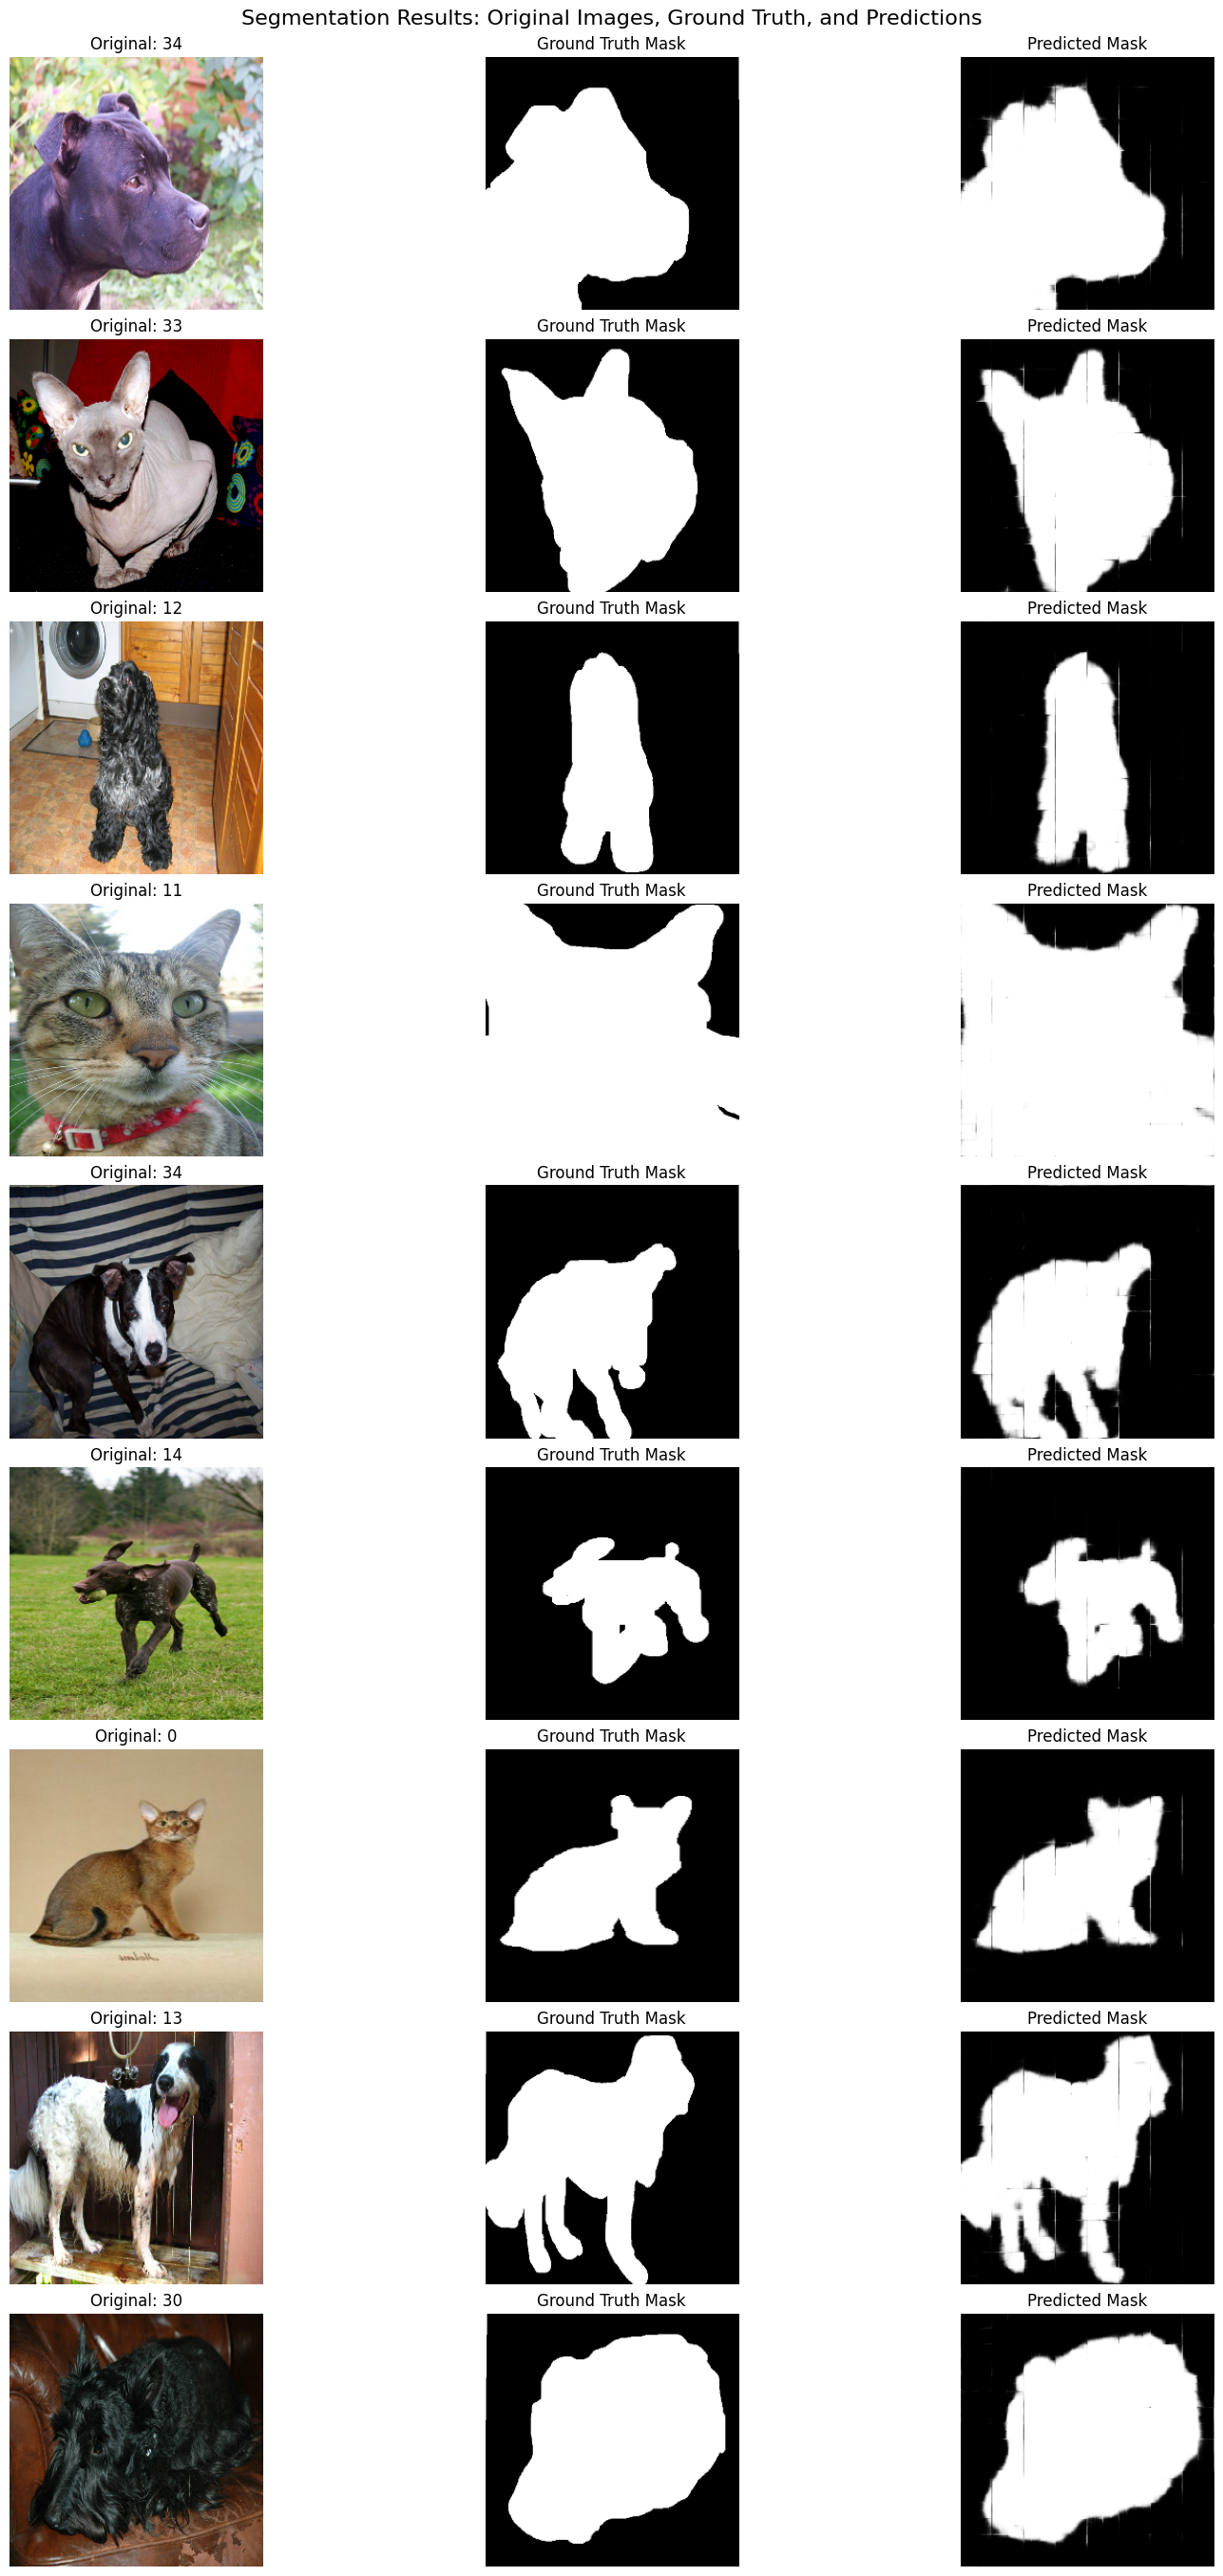

In [39]:

# Plot Confusion Matrix and F1 Score
# def plot_confusion_and_f1(y_true, y_pred, num_classes, title="Confusion Matrix"):
#     cm = confusion_matrix(y_true, y_pred)
#     f1 = f1_score(y_true, y_pred, average='weighted')
#     fig, ax = plt.subplots(figsize=(10, 10))
#     c = ConfusionMatrixDisplay(cm, display_labels=range(num_classes))
#     c.plot(ax=ax)
#     ax.set_title(f"{title}\nF1 Score: {f1:.4f}")
#     plt.show()
#     print(classification_report(y_true, y_pred))

# # Evaluation Method for Multi-Task Models
# def eval_multitask_models(model, train_data, test_data, num_classes, history):
#     # Predictions on training data
#     train_predictions = model.predict(train_data)
#     train_classification_predictions, _ = train_predictions
#     train_ground_truth_labels = []

#     for _, (label, _) in train_data:
#         train_ground_truth_labels.extend(label.numpy())

#     train_predicted_labels = np.argmax(train_classification_predictions, axis=1)
#     plot_confusion_and_f1(train_ground_truth_labels, train_predicted_labels, num_classes, "Training Confusion Matrix")

#     # Predictions on test data
#     test_predictions = model.predict(test_data)
#     test_classification_predictions, test_segmentation_predictions = test_predictions
#     test_ground_truth_labels, test_ground_truth_masks = [], []

#     for _, (label, mask) in test_data:
#         test_ground_truth_labels.extend(label.numpy())
#         test_ground_truth_masks.extend(mask.numpy())

#     # Test Confusion Matrix
#     test_predicted_labels = np.argmax(test_classification_predictions, axis=1)
#     plot_confusion_and_f1(test_ground_truth_labels, test_predicted_labels, num_classes, "Testing Confusion Matrix")

#     # Check available history keys for metrics plotting
#     print(f"Available keys in history: {history.history.keys()}")

#     # Plot Training and Validation Loss and Accuracy
#     fig = plt.figure(figsize=[15, 8])
#     ax = fig.add_subplot(2, 1, 1)
#     ax.plot(history.history['loss'], label='Overall Loss')
#     ax.plot(history.history.get('classification_head_loss', []), label='Classification Loss')
#     ax.plot(history.history.get('segmentation_head_loss', []), label='Segmentation Loss')
#     ax.plot(history.history.get('classification_head_accuracy', []), label='Classification Accuracy')
#     ax.plot(history.history.get('segmentation_head_accuracy', []), label='Segmentation Accuracy')
#     ax.legend()
#     ax.set_title('Training Loss and Accuracy')

#     ax = fig.add_subplot(2, 1, 2)
#     ax.plot(history.history['val_loss'], label='Overall Loss')
#     ax.plot(history.history.get('val_classification_head_loss', []), label='Validation Classification Loss')
#     ax.plot(history.history.get('val_segmentation_head_loss', []), label='Validation Segmentation Loss')
#     ax.plot(history.history.get('val_classification_head_accuracy', []), label='Validation Classification Accuracy')
#     ax.plot(history.history.get('val_segmentation_head_accuracy', []), label='Validation Segmentation Accuracy')
#     ax.legend()
#     ax.set_title('Validation Loss and Accuracy')

#     plt.show()

# Function to unprocess the images
def unprocess_image(image):
    image = image * 255.0 + 127.5
    return image

# Plotting Function with Dynamic Prediction
def plot_segmentation_results_with_predictions(model, dataset, num_plot=27, image_size=256):
    num_rows = (num_plot + 2) // 3
    fig, axs = plt.subplots(num_rows, 3, figsize=(15, num_rows * 3), constrained_layout=True)

    row_idx = 0

    for image, output in dataset.take(1).as_numpy_iterator():
        # Predict for the same batch
        predictions = model.predict(image)[1]

        for i in range(num_plot):
            col_idx = i % 3
            row_idx = i // 3

            if col_idx == 0:
                # Original Image
                axs[row_idx, col_idx].imshow(np.squeeze(unprocess_image(image[row_idx, ...])) / 255.0)
                axs[row_idx, col_idx].set_title(f"Original: {output[0][row_idx]}")
                axs[row_idx, col_idx].axis('off')

            elif col_idx == 1:
                # Ground Truth Segmentation Mask
                axs[row_idx, col_idx].imshow(np.squeeze(output[1][row_idx, ...]), cmap='gray')
                axs[row_idx, col_idx].set_title("Ground Truth Mask")
                axs[row_idx, col_idx].axis('off')

            elif col_idx == 2:
                # Predicted Segmentation Mask
                axs[row_idx, col_idx].imshow(np.squeeze(predictions[row_idx, :, :, 0]), cmap='gray')
                axs[row_idx, col_idx].set_title("Predicted Mask")
                axs[row_idx, col_idx].axis('off')

    # Turn off extra subplots
    for i in range(num_plot, num_rows * 3):
        axs.flatten()[i].axis('off')

    fig.suptitle("Segmentation Results: Original Images, Ground Truth, and Predictions", fontsize=16)
    plt.show()

# Evaluate and visualize for the fine-tuned MobileNetV3Small model
# eval_multitask_models(fine_tuned_mobilenet_model, train_class_seg, test_class_seg, num_classes=37, history=history_fine_tuned_mobilenet)
plot_segmentation_results_with_predictions(fine_tuned_mobilenet_model, train_class_seg, num_plot=27, image_size=image_size)

In [21]:
#
# Evaluation
#
# You should evaluate both your networks for both tasks. To help generate metrics and plots, you may want to pull out the labels from the dataset
# which you could do with something like the following:
#
# y_class_test = np.concatenate([y[0] for x,y in test_class_seg.as_numpy_iterator()])
# y_seg_test = np.concatenate([y[1] for x,y in test_class_seg.as_numpy_iterator()])
# 
# For evaluating the two tasks, the classification task is just like all the other classification tasks you've done this semseter and you can follow
# how these have been dealt with. For the segmentation task, one way to look at this is as a binary classification task as you're classifiying each 
# pixel into foreground and background. With that in mind you could do something like this:
#
# class_preds, seg_preds = my_awesome_network.predict(test_class_seg)
# seg_preds_flat = seg_preds.reshape(-1) > 0.5 # flatten predictions, turn into boolean vector where true is fgnd and false is bkgnd
# seg_gt_flat = y_seg_test.reshape(-1) > 0.5 # same as above, but for the ground truth, need to have both as a boolean vector
# cm = sklearn.metrics.confusion_matrix(seg_gt_flat, seg_preds_flat)
#
# You could also look at other segmentation specific metrics as a way to evaluate performance

In [22]:
# For your write-up, you should include:
# - A discussion of what pre-processing (i.e. resizing, colour conversion, augmentation, etc.) you apply to the data and why.
# - Details of two implemented methods. This should include a details of the final “from-scratch” approach and justification 
#   for the chosen design, and details of changes made to MobileNetV3Small for the “fine-tuned” approach. Details on how the 
#   models are trained are also to be provided. 
# - An evaluation that compares the two models for the two tasks (classification and semantic segmentation). Your evaluation 
#   should discuss overall model performance, how it differs between the two approaches, and include figures if/where necessary.
# - A discussion of methods that were explored to improve performance for both models and mitigate identified issues, and potentially 
#   other methods that were considered but not implemented due to computational constraints. See the assignment brief for further 
#   details.
# Your write-up should be supported by appropriate figures and tables. Figures and tables should have numbers and meaningful captions
#
# SEE THE ASSIGNMENT BRIEF ON CANVAS FOR MORE DETAILS AND NOTE THAT A NOTEBOOK FILE DOES NOT CONSTITUTE A VALID SUBMISSION. 
# YOU SHOULD WRITE UP YOUR RESPONSE IN A SEPARATE DOCUMENT